
# Project: TMDb Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


We are planing to invest in the movies business, so our aim is to understand the sector in order to know what are the best investment options available to us.   
In this project, we will be analyzing data associated with The Movie Database (TMDb), including budget, production companies, and revenue, which contains information about 10,000 movies. In particular, we will be interested in :
1. Which genre of movies are on trend, so that we define the direction of our investment ?  
1. What is the minimum amount of budget we should allocate to the choosen movie genre, in order to score in the highest movie revenues ?
1. Which companies are the best in the genre of movie we are targeting ?
1. Does having a website for the genre that is of interest to us help improve revenue ?


> **Report date : December 2022**     
> **Written by : [Ekoue LOGOSU-TEKO](https://www.linkedin.com/in/ekouelogosuteko/?locale=en_US)**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline


from typing import List, Tuple

In [2]:
def unpipe_features(df:pd.DataFrame, features:List[str], separator:str="|")->pd.DataFrame:
    """
        Remove pipes (or any given separator) from features cells, and create new lines
            based on each item of the cell
    """
    for feature in features:
        print("********************"*5)
        print("Working on feature : {} ".format(feature))
        df = unpipe_feature(df=df, feature=feature, separator=separator)
        print("Work on feature {} ended".format(feature))
    return df

In [3]:
def unpipe_feature(df:pd.DataFrame, feature:str, separator:str="|")->pd.DataFrame:
    """
        Remove pipes (or any given separator) from a feature cell, and create new lines
            based on each item of the cell
    
        References : 
          - https://stackoverflow.com/questions/41927973/pandas-dataframe-pipe-separated-values-in-a-cell
          - https://docs.python.org/3/library/itertools.html
    """
    
    print("Shape of dataset before processing : {}".format(df.shape))
    print("........"*8)
    
    all_rows = [] #np.empty(shape=df.shape)
    
    # duplicate feature, and putting an underscore at the end of the duplicated column 
    target_col = "{}_".format(feature)
    df[target_col] = df[feature]
    
    for index,row in df.iterrows(): 
        print("Processing row index : {} ".format(index))
#         print(row)
#         print("..."*2)
#         print(row["popularity"])
#         print("..."*2)
#         print(index)
#         print("---"*8)

        # split the datas in list
        col_datas:list[str] = str(row[target_col]).split(separator)
            
        rows = [ list(row[df.columns[:-1]]) + [data] for data in col_datas]
        all_rows += rows
        print("-------"*6)
        
    print("Processed all rows in dataset")    
    df_2 = pd.DataFrame(data=all_rows, columns=df.columns)
    df_2[feature]=df_2[target_col]
    
    df_2.drop([target_col],axis=1,inplace=True)
    print("Generated new dataframe")
    print("Shape of new dataset : {}".format(df_2.shape))
    print("........"*8)
    
    return df_2
    
    

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [4]:
df = pd.read_csv("tmdb-movies.csv")
df.head(2).T

,0,1
id,135397,76341
imdb_id,tt0369610,tt1392190
popularity,32.985763,28.419936
budget,150000000,150000000
revenue,1513528810,378436354
original_title,Jurassic World,Mad Max: Fury Road
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...
homepage,http://www.jurassicworld.com/,http://www.madmaxmovie.com/
director,Colin Trevorrow,George Miller
tagline,The park is open.,What a Lovely Day.


The features name are self-explanotory, but we will still explain them in order to clear any confusion that may exists :    
* id : movie id, in TMDb database
* imdb_id : movie id, in IMDd database
* popularity : movie popularity score, in IMDb database
* budget : budget used to make the movie
* revenue : revenue generated by the movie
* original_title : movie original title
* cast : cast team of the movie
* homepage : movie website
* director : movie casting team director
* tagline : the movie tagline
* keywords : movie keywords/hashtags
* overview : movie overview
* runtime : movie runtime, in minutes
* genres : movie genres
* production_companies : companies which producted the movie
* release_date : movie release date
* vote_count : number of person which give a rating for the movie
* vote_average : average rating for the movie
* release_year : movie release year
* budget_adj : budget of the movie in terms of 2010 dollars, accounting for inflation over time
* revenue_adj : revenue of the movie in terms of 2010 dollars, accounting for inflation over time


### Getting an overview of the data

In [5]:
# Checking the number of samples and features in the dataset
df.shape

(10866, 21)

In [6]:
# Checking the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [7]:
# Number of N/A values per feature
df.isna().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [8]:
# Number of NULL values per feature
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

**Data Overview conclustion** :      
* Over a total of 10866 samples, `homepage` feature has 7930 null value. Based on our search over the net, we know that null value here is due to not having a website.    
* The other samples which have null values will be dropped.

### Data Cleaning

Dropping the null values, while having `homepage` as feature let us with a dataset of shape (1992, 21), which is too little for our analysis.   
So, we will first create a new feature, `no_website`, which will tell weither a movie has a homepage or not (assuming that not having a homepage in the dataset is due to not having one hosted, and not due to not having find it).

In [9]:
# Creating a new feature, no_website, to tell weither the movie has a website or not
df["no_website"] = df["homepage"].isnull() | df["homepage"].isna() 
df.head(3).T

,0,1,2
id,135397,76341,262500
imdb_id,tt0369610,tt1392190,tt2908446
popularity,32.985763,28.419936,13.112507
budget,150000000,150000000,110000000
revenue,1513528810,378436354,295238201
original_title,Jurassic World,Mad Max: Fury Road,Insurgent
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Shailene Woodley|Theo James|Kate Winslet|Ansel...
homepage,http://www.jurassicworld.com/,http://www.madmaxmovie.com/,http://www.thedivergentseries.movie/#insurgent
director,Colin Trevorrow,George Miller,Robert Schwentke
tagline,The park is open.,What a Lovely Day.,One Choice Can Destroy You


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [11]:
df["no_website"].unique()

array([False,  True])

In [12]:
# Checking the current shape of the dataframe
df.shape

(10866, 22)

In [13]:
# Droping homepage feature
df.drop(["homepage"],axis=1,inplace=True)

# Checking that homepage was removed
df.shape

(10866, 21)

In [14]:
# Drop null value
df.dropna(inplace=True)

# Looking at the new shape of our dataset
df.shape

(7031, 21)

In [15]:
# Making sure there is no more null or N/A value

In [16]:
df.isna().sum()

id                      0
imdb_id                 0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
tagline                 0
keywords                0
overview                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_count              0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
no_website              0
dtype: int64

In [17]:
df.isnull().sum()

id                      0
imdb_id                 0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
tagline                 0
keywords                0
overview                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_count              0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
no_website              0
dtype: int64

In [18]:
df.head(3).T

,0,1,2
id,135397,76341,262500
imdb_id,tt0369610,tt1392190,tt2908446
popularity,32.985763,28.419936,13.112507
budget,150000000,150000000,110000000
revenue,1513528810,378436354,295238201
original_title,Jurassic World,Mad Max: Fury Road,Insurgent
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Shailene Woodley|Theo James|Kate Winslet|Ansel...
director,Colin Trevorrow,George Miller,Robert Schwentke
tagline,The park is open.,What a Lovely Day.,One Choice Can Destroy You
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,future|chase|post-apocalyptic|dystopia|australia,based on novel|revolution|dystopia|sequel|dyst...


In our current dataset, we have release_date and release_year. We will focus on the year, and drop the date.

In [19]:
df.drop(["release_date"],axis=1,inplace=True)
df.head(3).T

,0,1,2
id,135397,76341,262500
imdb_id,tt0369610,tt1392190,tt2908446
popularity,32.985763,28.419936,13.112507
budget,150000000,150000000,110000000
revenue,1513528810,378436354,295238201
original_title,Jurassic World,Mad Max: Fury Road,Insurgent
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Shailene Woodley|Theo James|Kate Winslet|Ansel...
director,Colin Trevorrow,George Miller,Robert Schwentke
tagline,The park is open.,What a Lovely Day.,One Choice Can Destroy You
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,future|chase|post-apocalyptic|dystopia|australia,based on novel|revolution|dystopia|sequel|dyst...


In [20]:
# Confirming if we have duplicate value
df.duplicated().sum()

1

In [21]:
# Removing duplicates
df.drop_duplicates(inplace=True)

In [22]:
# Making sure all duplicates are gone
df.duplicated().sum()

0

The dataset is now ready to be used in the Exploratory Data Analysis

<a id='eda'></a>
## Exploratory Data Analysis

 

### Which genres of movies are on trend ?   
We will explore the relationship between movie genres and production years. We will try to understand how movies production evolved over the years, and which genres of movie are the most produced in recent years.    

In [23]:
# List of movie genres
df["genres"].unique()

array(['Action|Adventure|Science Fiction|Thriller',
       'Adventure|Science Fiction|Thriller',
       'Action|Adventure|Science Fiction|Fantasy', ...,
       'Adventure|Comedy|Fantasy|Science Fiction',
       'Adventure|Drama|Action|Family|Foreign',
       'Comedy|Family|Mystery|Romance'], dtype=object)

In [24]:
# Current shape of dataset
df.shape

(7030, 20)

We will first remove the pipes from the `genres` cells, in order to have the dataset in the right format for our analysis.

In [25]:
to_unpipes =["genres"]  #["cast","keywords","genres","production_companies"]

df = unpipe_features(df=df, features=to_unpipes, separator="|")  # df.iloc[:10,:]
df.head(3).T

****************************************************************************************************
Working on feature : genres 
Shape of dataset before processing : (7030, 20)
................................................................
Processing row index : 0 
------------------------------------------
Processing row index : 1 
------------------------------------------
Processing row index : 2 
------------------------------------------
Processing row index : 3 
------------------------------------------
Processing row index : 4 
------------------------------------------
Processing row index : 5 
------------------------------------------
Processing row index : 6 
------------------------------------------
Processing row index : 7 
------------------------------------------
Processing row index : 8 
------------------------------------------
Processing row index : 9 
------------------------------------------
Processing row index : 10 
----------------------------------------

Processing row index : 184 
------------------------------------------
Processing row index : 185 
------------------------------------------
Processing row index : 186 
------------------------------------------
Processing row index : 187 
------------------------------------------
Processing row index : 188 
------------------------------------------
Processing row index : 191 
------------------------------------------
Processing row index : 193 
------------------------------------------
Processing row index : 195 
------------------------------------------
Processing row index : 197 
------------------------------------------
Processing row index : 198 
------------------------------------------
Processing row index : 199 
------------------------------------------
Processing row index : 200 
------------------------------------------
Processing row index : 201 
------------------------------------------
Processing row index : 204 
------------------------------------------
Proces

Processing row index : 481 
------------------------------------------
Processing row index : 482 
------------------------------------------
Processing row index : 484 
------------------------------------------
Processing row index : 485 
------------------------------------------
Processing row index : 488 
------------------------------------------
Processing row index : 492 
------------------------------------------
Processing row index : 493 
------------------------------------------
Processing row index : 495 
------------------------------------------
Processing row index : 500 
------------------------------------------
Processing row index : 505 
------------------------------------------
Processing row index : 506 
------------------------------------------
Processing row index : 509 
------------------------------------------
Processing row index : 510 
------------------------------------------
Processing row index : 514 
------------------------------------------
Proces

------------------------------------------
Processing row index : 884 
------------------------------------------
Processing row index : 885 
------------------------------------------
Processing row index : 893 
------------------------------------------
Processing row index : 896 
------------------------------------------
Processing row index : 897 
------------------------------------------
Processing row index : 898 
------------------------------------------
Processing row index : 903 
------------------------------------------
Processing row index : 905 
------------------------------------------
Processing row index : 906 
------------------------------------------
Processing row index : 908 
------------------------------------------
Processing row index : 909 
------------------------------------------
Processing row index : 915 
------------------------------------------
Processing row index : 917 
------------------------------------------
Processing row index : 918 
------

------------------------------------------
Processing row index : 1351 
------------------------------------------
Processing row index : 1352 
------------------------------------------
Processing row index : 1353 
------------------------------------------
Processing row index : 1354 
------------------------------------------
Processing row index : 1355 
------------------------------------------
Processing row index : 1356 
------------------------------------------
Processing row index : 1359 
------------------------------------------
Processing row index : 1362 
------------------------------------------
Processing row index : 1363 
------------------------------------------
Processing row index : 1364 
------------------------------------------
Processing row index : 1365 
------------------------------------------
Processing row index : 1366 
------------------------------------------
Processing row index : 1367 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 1554 
------------------------------------------
Processing row index : 1556 
------------------------------------------
Processing row index : 1557 
------------------------------------------
Processing row index : 1558 
------------------------------------------
Processing row index : 1560 
------------------------------------------
Processing row index : 1561 
------------------------------------------
Processing row index : 1562 
------------------------------------------
Processing row index : 1564 
------------------------------------------
Processing row index : 1565 
------------------------------------------
Processing row index : 1567 
------------------------------------------
Processing row index : 1568 
------------------------------------------
Processing row index : 1569 
------------------------------------------
Processing row index : 1570 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 2159 
------------------------------------------
Processing row index : 2160 
------------------------------------------
Processing row index : 2161 
------------------------------------------
Processing row index : 2162 
------------------------------------------
Processing row index : 2164 
------------------------------------------
Processing row index : 2168 
------------------------------------------
Processing row index : 2172 
------------------------------------------
Processing row index : 2173 
------------------------------------------
Processing row index : 2174 
------------------------------------------
Processing row index : 2177 
------------------------------------------
Processing row index : 2181 
------------------------------------------
Processing row index : 2183 
------------------------------------------
Processing row index : 2186 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 2736 
------------------------------------------
Processing row index : 2738 
------------------------------------------
Processing row index : 2739 
------------------------------------------
Processing row index : 2740 
------------------------------------------
Processing row index : 2742 
------------------------------------------
Processing row index : 2743 
------------------------------------------
Processing row index : 2744 
------------------------------------------
Processing row index : 2745 
------------------------------------------
Processing row index : 2746 
------------------------------------------
Processing row index : 2747 
------------------------------------------
Processing row index : 2749 
------------------------------------------
Processing row index : 2750 
------------------------------------------
Processing row index : 2751 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 2959 
------------------------------------------
Processing row index : 2962 
------------------------------------------
Processing row index : 2963 
------------------------------------------
Processing row index : 2964 
------------------------------------------
Processing row index : 2965 
------------------------------------------
Processing row index : 2966 
------------------------------------------
Processing row index : 2968 
------------------------------------------
Processing row index : 2969 
------------------------------------------
Processing row index : 2972 
------------------------------------------
Processing row index : 2973 
------------------------------------------
Processing row index : 2974 
------------------------------------------
Processing row index : 2975 
------------------------------------------
Processing row index : 2976 
------------------------------------------
Processing row index 

Processing row index : 3471 
------------------------------------------
Processing row index : 3472 
------------------------------------------
Processing row index : 3473 
------------------------------------------
Processing row index : 3474 
------------------------------------------
Processing row index : 3475 
------------------------------------------
Processing row index : 3476 
------------------------------------------
Processing row index : 3479 
------------------------------------------
Processing row index : 3480 
------------------------------------------
Processing row index : 3481 
------------------------------------------
Processing row index : 3482 
------------------------------------------
Processing row index : 3483 
------------------------------------------
Processing row index : 3484 
------------------------------------------
Processing row index : 3485 
------------------------------------------
Processing row index : 3486 
-----------------------------------

Processing row index : 4052 
------------------------------------------
Processing row index : 4053 
------------------------------------------
Processing row index : 4054 
------------------------------------------
Processing row index : 4056 
------------------------------------------
Processing row index : 4057 
------------------------------------------
Processing row index : 4058 
------------------------------------------
Processing row index : 4064 
------------------------------------------
Processing row index : 4065 
------------------------------------------
Processing row index : 4066 
------------------------------------------
Processing row index : 4067 
------------------------------------------
Processing row index : 4069 
------------------------------------------
Processing row index : 4070 
------------------------------------------
Processing row index : 4071 
------------------------------------------
Processing row index : 4072 
-----------------------------------

Processing row index : 4370 
------------------------------------------
Processing row index : 4371 
------------------------------------------
Processing row index : 4372 
------------------------------------------
Processing row index : 4373 
------------------------------------------
Processing row index : 4374 
------------------------------------------
Processing row index : 4375 
------------------------------------------
Processing row index : 4376 
------------------------------------------
Processing row index : 4377 
------------------------------------------
Processing row index : 4378 
------------------------------------------
Processing row index : 4379 
------------------------------------------
Processing row index : 4380 
------------------------------------------
Processing row index : 4381 
------------------------------------------
Processing row index : 4382 
------------------------------------------
Processing row index : 4383 
-----------------------------------

------------------------------------------
Processing row index : 4806 
------------------------------------------
Processing row index : 4810 
------------------------------------------
Processing row index : 4814 
------------------------------------------
Processing row index : 4817 
------------------------------------------
Processing row index : 4834 
------------------------------------------
Processing row index : 4836 
------------------------------------------
Processing row index : 4842 
------------------------------------------
Processing row index : 4844 
------------------------------------------
Processing row index : 4846 
------------------------------------------
Processing row index : 4847 
------------------------------------------
Processing row index : 4851 
------------------------------------------
Processing row index : 4855 
------------------------------------------
Processing row index : 4859 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 5250 
------------------------------------------
Processing row index : 5251 
------------------------------------------
Processing row index : 5252 
------------------------------------------
Processing row index : 5253 
------------------------------------------
Processing row index : 5254 
------------------------------------------
Processing row index : 5255 
------------------------------------------
Processing row index : 5256 
------------------------------------------
Processing row index : 5257 
------------------------------------------
Processing row index : 5258 
------------------------------------------
Processing row index : 5259 
------------------------------------------
Processing row index : 5260 
------------------------------------------
Processing row index : 5262 
------------------------------------------
Processing row index : 5263 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 5474 
------------------------------------------
Processing row index : 5475 
------------------------------------------
Processing row index : 5476 
------------------------------------------
Processing row index : 5477 
------------------------------------------
Processing row index : 5478 
------------------------------------------
Processing row index : 5479 
------------------------------------------
Processing row index : 5480 
------------------------------------------
Processing row index : 5482 
------------------------------------------
Processing row index : 5483 
------------------------------------------
Processing row index : 5484 
------------------------------------------
Processing row index : 5485 
------------------------------------------
Processing row index : 5486 
------------------------------------------
Processing row index : 5487 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 5888 
------------------------------------------
Processing row index : 5892 
------------------------------------------
Processing row index : 5894 
------------------------------------------
Processing row index : 5895 
------------------------------------------
Processing row index : 5900 
------------------------------------------
Processing row index : 5901 
------------------------------------------
Processing row index : 5904 
------------------------------------------
Processing row index : 5906 
------------------------------------------
Processing row index : 5907 
------------------------------------------
Processing row index : 5909 
------------------------------------------
Processing row index : 5912 
------------------------------------------
Processing row index : 5914 
------------------------------------------
Processing row index : 5929 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 6310 
------------------------------------------
Processing row index : 6312 
------------------------------------------
Processing row index : 6313 
------------------------------------------
Processing row index : 6314 
------------------------------------------
Processing row index : 6315 
------------------------------------------
Processing row index : 6318 
------------------------------------------
Processing row index : 6320 
------------------------------------------
Processing row index : 6321 
------------------------------------------
Processing row index : 6322 
------------------------------------------
Processing row index : 6323 
------------------------------------------
Processing row index : 6324 
------------------------------------------
Processing row index : 6325 
------------------------------------------
Processing row index : 6326 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 6686 
------------------------------------------
Processing row index : 6687 
------------------------------------------
Processing row index : 6688 
------------------------------------------
Processing row index : 6689 
------------------------------------------
Processing row index : 6692 
------------------------------------------
Processing row index : 6694 
------------------------------------------
Processing row index : 6695 
------------------------------------------
Processing row index : 6696 
------------------------------------------
Processing row index : 6697 
------------------------------------------
Processing row index : 6699 
------------------------------------------
Processing row index : 6700 
------------------------------------------
Processing row index : 6703 
------------------------------------------
Processing row index : 6705 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 7088 
------------------------------------------
Processing row index : 7089 
------------------------------------------
Processing row index : 7091 
------------------------------------------
Processing row index : 7093 
------------------------------------------
Processing row index : 7094 
------------------------------------------
Processing row index : 7095 
------------------------------------------
Processing row index : 7096 
------------------------------------------
Processing row index : 7097 
------------------------------------------
Processing row index : 7099 
------------------------------------------
Processing row index : 7100 
------------------------------------------
Processing row index : 7102 
------------------------------------------
Processing row index : 7104 
------------------------------------------
Processing row index : 7105 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 7340 
------------------------------------------
Processing row index : 7341 
------------------------------------------
Processing row index : 7343 
------------------------------------------
Processing row index : 7344 
------------------------------------------
Processing row index : 7345 
------------------------------------------
Processing row index : 7346 
------------------------------------------
Processing row index : 7347 
------------------------------------------
Processing row index : 7348 
------------------------------------------
Processing row index : 7349 
------------------------------------------
Processing row index : 7350 
------------------------------------------
Processing row index : 7351 
------------------------------------------
Processing row index : 7352 
------------------------------------------
Processing row index : 7354 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 7478 
------------------------------------------
Processing row index : 7479 
------------------------------------------
Processing row index : 7480 
------------------------------------------
Processing row index : 7481 
------------------------------------------
Processing row index : 7482 
------------------------------------------
Processing row index : 7483 
------------------------------------------
Processing row index : 7484 
------------------------------------------
Processing row index : 7486 
------------------------------------------
Processing row index : 7487 
------------------------------------------
Processing row index : 7488 
------------------------------------------
Processing row index : 7490 
------------------------------------------
Processing row index : 7491 
------------------------------------------
Processing row index : 7492 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 7863 
------------------------------------------
Processing row index : 7864 
------------------------------------------
Processing row index : 7865 
------------------------------------------
Processing row index : 7866 
------------------------------------------
Processing row index : 7867 
------------------------------------------
Processing row index : 7868 
------------------------------------------
Processing row index : 7869 
------------------------------------------
Processing row index : 7870 
------------------------------------------
Processing row index : 7871 
------------------------------------------
Processing row index : 7873 
------------------------------------------
Processing row index : 7874 
------------------------------------------
Processing row index : 7875 
------------------------------------------
Processing row index : 7876 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 8078 
------------------------------------------
Processing row index : 8079 
------------------------------------------
Processing row index : 8080 
------------------------------------------
Processing row index : 8081 
------------------------------------------
Processing row index : 8082 
------------------------------------------
Processing row index : 8083 
------------------------------------------
Processing row index : 8084 
------------------------------------------
Processing row index : 8085 
------------------------------------------
Processing row index : 8086 
------------------------------------------
Processing row index : 8087 
------------------------------------------
Processing row index : 8088 
------------------------------------------
Processing row index : 8089 
------------------------------------------
Processing row index : 8090 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 8378 
------------------------------------------
Processing row index : 8379 
------------------------------------------
Processing row index : 8380 
------------------------------------------
Processing row index : 8381 
------------------------------------------
Processing row index : 8382 
------------------------------------------
Processing row index : 8383 
------------------------------------------
Processing row index : 8384 
------------------------------------------
Processing row index : 8385 
------------------------------------------
Processing row index : 8386 
------------------------------------------
Processing row index : 8388 
------------------------------------------
Processing row index : 8389 
------------------------------------------
Processing row index : 8390 
------------------------------------------
Processing row index : 8391 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 8732 
------------------------------------------
Processing row index : 8733 
------------------------------------------
Processing row index : 8734 
------------------------------------------
Processing row index : 8735 
------------------------------------------
Processing row index : 8736 
------------------------------------------
Processing row index : 8737 
------------------------------------------
Processing row index : 8738 
------------------------------------------
Processing row index : 8739 
------------------------------------------
Processing row index : 8741 
------------------------------------------
Processing row index : 8742 
------------------------------------------
Processing row index : 8744 
------------------------------------------
Processing row index : 8745 
------------------------------------------
Processing row index : 8746 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 8915 
------------------------------------------
Processing row index : 8918 
------------------------------------------
Processing row index : 8919 
------------------------------------------
Processing row index : 8920 
------------------------------------------
Processing row index : 8921 
------------------------------------------
Processing row index : 8923 
------------------------------------------
Processing row index : 8924 
------------------------------------------
Processing row index : 8925 
------------------------------------------
Processing row index : 8926 
------------------------------------------
Processing row index : 8927 
------------------------------------------
Processing row index : 8928 
------------------------------------------
Processing row index : 8929 
------------------------------------------
Processing row index : 8930 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 9058 
------------------------------------------
Processing row index : 9059 
------------------------------------------
Processing row index : 9060 
------------------------------------------
Processing row index : 9063 
------------------------------------------
Processing row index : 9064 
------------------------------------------
Processing row index : 9065 
------------------------------------------
Processing row index : 9067 
------------------------------------------
Processing row index : 9068 
------------------------------------------
Processing row index : 9070 
------------------------------------------
Processing row index : 9071 
------------------------------------------
Processing row index : 9072 
------------------------------------------
Processing row index : 9073 
------------------------------------------
Processing row index : 9074 
------------------------------------------
Processing row index 

Processing row index : 9418 
------------------------------------------
Processing row index : 9420 
------------------------------------------
Processing row index : 9421 
------------------------------------------
Processing row index : 9427 
------------------------------------------
Processing row index : 9428 
------------------------------------------
Processing row index : 9429 
------------------------------------------
Processing row index : 9430 
------------------------------------------
Processing row index : 9432 
------------------------------------------
Processing row index : 9435 
------------------------------------------
Processing row index : 9440 
------------------------------------------
Processing row index : 9442 
------------------------------------------
Processing row index : 9444 
------------------------------------------
Processing row index : 9445 
------------------------------------------
Processing row index : 9448 
-----------------------------------

------------------------------------------
Processing row index : 9754 
------------------------------------------
Processing row index : 9756 
------------------------------------------
Processing row index : 9758 
------------------------------------------
Processing row index : 9760 
------------------------------------------
Processing row index : 9761 
------------------------------------------
Processing row index : 9762 
------------------------------------------
Processing row index : 9763 
------------------------------------------
Processing row index : 9764 
------------------------------------------
Processing row index : 9765 
------------------------------------------
Processing row index : 9766 
------------------------------------------
Processing row index : 9767 
------------------------------------------
Processing row index : 9768 
------------------------------------------
Processing row index : 9769 
------------------------------------------
Processing row index 

------------------------------------------
Processing row index : 10028 
------------------------------------------
Processing row index : 10031 
------------------------------------------
Processing row index : 10032 
------------------------------------------
Processing row index : 10033 
------------------------------------------
Processing row index : 10034 
------------------------------------------
Processing row index : 10035 
------------------------------------------
Processing row index : 10036 
------------------------------------------
Processing row index : 10037 
------------------------------------------
Processing row index : 10039 
------------------------------------------
Processing row index : 10040 
------------------------------------------
Processing row index : 10041 
------------------------------------------
Processing row index : 10043 
------------------------------------------
Processing row index : 10044 
------------------------------------------
Processi

------------------------------------------
Processing row index : 10446 
------------------------------------------
Processing row index : 10447 
------------------------------------------
Processing row index : 10448 
------------------------------------------
Processing row index : 10449 
------------------------------------------
Processing row index : 10450 
------------------------------------------
Processing row index : 10451 
------------------------------------------
Processing row index : 10452 
------------------------------------------
Processing row index : 10453 
------------------------------------------
Processing row index : 10454 
------------------------------------------
Processing row index : 10455 
------------------------------------------
Processing row index : 10456 
------------------------------------------
Processing row index : 10457 
------------------------------------------
Processing row index : 10458 
------------------------------------------
Processi

------------------------------------------
Processing row index : 10641 
------------------------------------------
Processing row index : 10642 
------------------------------------------
Processing row index : 10643 
------------------------------------------
Processing row index : 10644 
------------------------------------------
Processing row index : 10645 
------------------------------------------
Processing row index : 10646 
------------------------------------------
Processing row index : 10647 
------------------------------------------
Processing row index : 10648 
------------------------------------------
Processing row index : 10649 
------------------------------------------
Processing row index : 10650 
------------------------------------------
Processing row index : 10651 
------------------------------------------
Processing row index : 10652 
------------------------------------------
Processing row index : 10653 
------------------------------------------
Processi

,0,1,2
id,135397,135397,135397
imdb_id,tt0369610,tt0369610,tt0369610
popularity,32.985763,32.985763,32.985763
budget,150000000,150000000,150000000
revenue,1513528810,1513528810,1513528810
original_title,Jurassic World,Jurassic World,Jurassic World
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...
director,Colin Trevorrow,Colin Trevorrow,Colin Trevorrow
tagline,The park is open.,The park is open.,The park is open.
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,monster|dna|tyrannosaurus rex|velociraptor|island,monster|dna|tyrannosaurus rex|velociraptor|island


In [26]:
# Current shape of dataset
df.shape

(18253, 20)

In [27]:
# List of movie genres
df["genres"].unique()

array(['Action', 'Adventure', 'Science Fiction', 'Thriller', 'Fantasy',
       'Crime', 'Western', 'Drama', 'Family', 'Animation', 'Comedy',
       'Mystery', 'Romance', 'War', 'History', 'Music', 'Horror',
       'Documentary', 'TV Movie', 'Foreign'], dtype=object)

In [28]:
# Movie genres count
df["genres"].nunique()

20

In [29]:
# Confirming if we have duplicate value
df.duplicated().sum()

0

In [30]:
# Let us recall our dataset structure
df.head(2).T

,0,1
id,135397,135397
imdb_id,tt0369610,tt0369610
popularity,32.985763,32.985763
budget,150000000,150000000
revenue,1513528810,1513528810
original_title,Jurassic World,Jurassic World
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...
director,Colin Trevorrow,Colin Trevorrow
tagline,The park is open.,The park is open.
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,monster|dna|tyrannosaurus rex|velociraptor|island


In [31]:
# Let us understand the timeframe over which our dataset is located
year_desc = df.describe()["release_year"]
year_desc

count    18253.000000
mean      1999.023777
std         13.312253
min       1960.000000
25%       1991.000000
50%       2002.000000
75%       2010.000000
max       2015.000000
Name: release_year, dtype: float64

So we have movies from 1960 to 2015.    
In practice, we should go back and collect daats in order to also have observations from 2015 to 2022 (year of my report). But since it is a sample coming from Kaggle, we will limit our analysis to 2015.

In [32]:
min_year =  year_desc.loc["min"]
max_year =  year_desc.loc["max"]

min_year, max_year

(1960.0, 2015.0)

**Let us understand the movies production evolution over the years**

In [33]:
# Number of movies produced per year
movies_per_year_counts = df.groupby("release_year").count()
movies_per_year_counts

,id,imdb_id,popularity,budget,revenue,original_title,cast,director,tagline,keywords,overview,runtime,genres,production_companies,vote_count,vote_average,budget_adj,revenue_adj,no_website
release_year,,,,,,,,,,,,,,,,,,,
1960,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
1961,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63,63
1962,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73
1963,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82
1964,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
1965,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70
1966,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102,102
1967,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
1968,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83


In [34]:
movies_per_year_counts = movies_per_year_counts.iloc[:,1]
#movies_per_year_counts

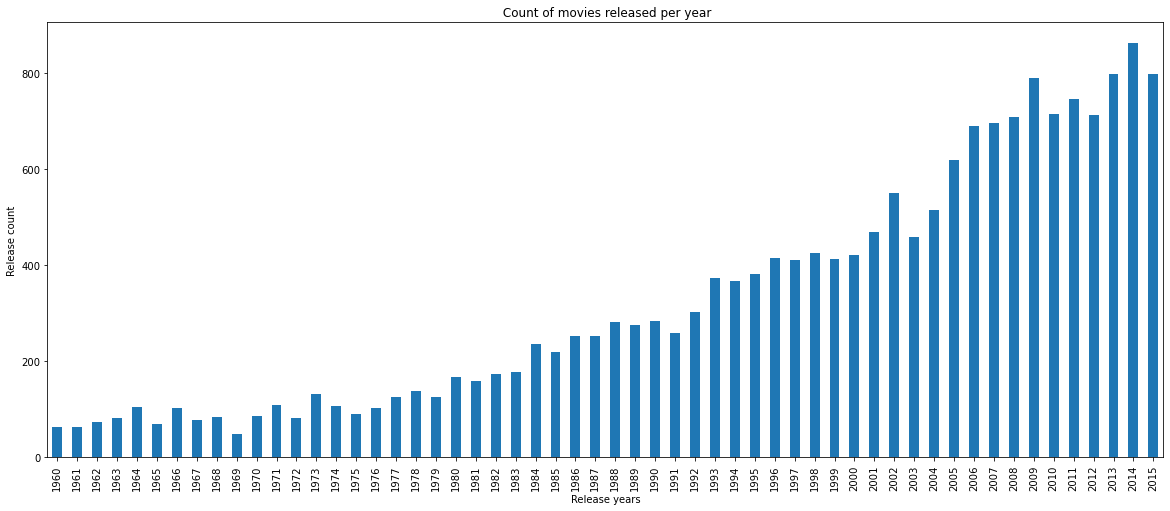

In [35]:
movies_per_year_counts.plot(kind="bar", figsize=(20,8));

plt.xlabel("Release years")
plt.ylabel("Release count")
plt.title(" Count of movies released per year");

There are more and more movies produced over the years. We can confirm that it is a very active domain, and therefore a good investment project.

In [36]:
# Number of movie genres produced per year
genres_per_year_counts = df.groupby(["release_year","genres"]).count()
genres_per_year_counts

id  imdb_id  popularity  budget  revenue  \
release_year genres                                                       
1960         Action             5        5           5       5        5   
             Adventure          5        5           5       5        5   
             Comedy             7        7           7       7        7   
             Crime              2        2           2       2        2   
             Drama             10       10          10      10       10   
...                           ...      ...         ...     ...      ...   
2015         Science Fiction   54       54          54      54       54   
             TV Movie           6        6           6       6        6   
             Thriller         103      103         103     103      103   
             War                6        6           6       6        6   
             Western            4        4           4       4        4   

                              original_title  cast  director  tagline  \
release_year genres                                                     
1960         Action                        5     5         5        5   
             Adventure                     5     5         5        5   
             Comedy                        7     7         7        7   
             Crime                         2     2         2        2   
             Drama                        10    10        10       10   
...                                      ...   ...       ...      ...   
2015         Science Fiction              54    54        54       54   
             TV Movie                      6     6         6        6   
             Thriller                    103   103       103      103   
             War                           6     6         6        6   
             Western                       4     4         4        4   

                              keywords  overview  runtime  \
release_year genres                                         
1960         Action                  5         5        5   
             Adventure               5         5        5   
             Comedy                  7         7        7   
             Crime                   2         2        2   
             Drama                  10        10       10   
...                                ...       ...      ...   
2015         Science Fiction        54        54       54   
             TV Movie                6         6        6   
             Thriller              103       103      103   
             War                     6         6        6   
             Western                 4         4        4   

                              production_companies  vote_count  vote_average  \
release_year genres                                                            
1960         Action                              5           5             5   
             Adventure                           5           5             5   
             Comedy                              7           7             7   
             Crime                               2           2             2   
             Drama                              10          10            10   
...                                            ...         ...           ...   
2015         Science Fiction                    54          54            54   
             TV Movie                            6           6             6   
             Thriller                          103         103           103   
             War                                 6           6             6   
             Western                             4           4             4   

                              budget_adj  revenue_adj  no_website  
release_year genres                                                
1960         Action                    5            5           5  
             Adventure                 5            5           5 

In [37]:
genres_per_year_counts = genres_per_year_counts.iloc[:,1]
genres_per_year_counts

release_year  genres         
1960          Action               5
              Adventure            5
              Comedy               7
              Crime                2
              Drama               10
                                ... 
2015          Science Fiction     54
              TV Movie             6
              Thriller           103
              War                  6
              Western              4
Name: imdb_id, Length: 1000, dtype: int64

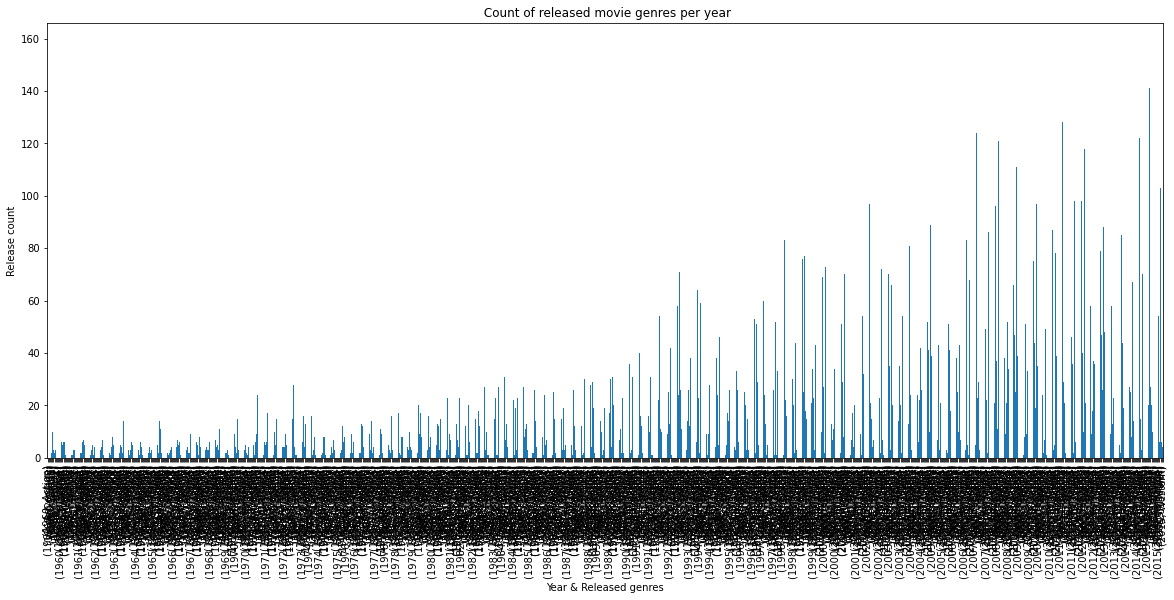

In [38]:
# Ploting the released genres per year for better observation
genres_per_year_counts.plot(kind="bar", figsize=(20,8));

plt.xlabel("Year & Released genres")
plt.ylabel("Release count")
plt.title(" Count of released movie genres per year");

There are too many observations to draw a good conclusion. So we will observe data for the last 3 years.

In [39]:
# year from which to analyze datas
analyze_from = max_year - 3

In [40]:
genres_per_year_counts = df.query(" release_year >= {} ".format(analyze_from)) \
                            .groupby(["release_year","genres"]) \
                            .count()

genres_per_year_counts

id  imdb_id  popularity  budget  revenue  \
release_year genres                                                       
2012         Action            73       73          73      73       73   
             Adventure         36       36          36      36       36   
             Animation         24       24          24      24       24   
             Comedy            98       98          98      98       98   
             Crime             40       40          40      40       40   
...                           ...      ...         ...     ...      ...   
2015         Science Fiction   54       54          54      54       54   
             TV Movie           6        6           6       6        6   
             Thriller         103      103         103     103      103   
             War                6        6           6       6        6   
             Western            4        4           4       4        4   

                              original_title  cast  director  tagline  \
release_year genres                                                     
2012         Action                       73    73        73       73   
             Adventure                    36    36        36       36   
             Animation                    24    24        24       24   
             Comedy                       98    98        98       98   
             Crime                        40    40        40       40   
...                                      ...   ...       ...      ...   
2015         Science Fiction              54    54        54       54   
             TV Movie                      6     6         6        6   
             Thriller                    103   103       103      103   
             War                           6     6         6        6   
             Western                       4     4         4        4   

                              keywords  overview  runtime  \
release_year genres                                         
2012         Action                 73        73       73   
             Adventure              36        36       36   
             Animation              24        24       24   
             Comedy                 98        98       98   
             Crime                  40        40       40   
...                                ...       ...      ...   
2015         Science Fiction        54        54       54   
             TV Movie                6         6        6   
             Thriller              103       103      103   
             War                     6         6        6   
             Western                 4         4        4   

                              production_companies  vote_count  vote_average  \
release_year genres                                                            
2012         Action                             73          73            73   
             Adventure                          36          36            36   
             Animation                          24          24            24   
             Comedy                             98          98            98   
             Crime                              40          40            40   
...                                            ...         ...           ...   
2015         Science Fiction                    54          54            54   
             TV Movie                            6           6             6   
             Thriller                          103         103           103   
             War                                 6           6             6   
             Western                             4           4             4   

                              budget_adj  revenue_adj  no_website  
release_year genres                                                
2012         Action                   73           73          73  
             Adventure                36           36          36 

In [41]:
genres_per_year_counts = genres_per_year_counts.iloc[:,1]
genres_per_year_counts

release_year  genres         
2012          Action              73
              Adventure           36
              Animation           24
              Comedy              98
              Crime               40
                                ... 
2015          Science Fiction     54
              TV Movie             6
              Thriller           103
              War                  6
              Western              4
Name: imdb_id, Length: 77, dtype: int64

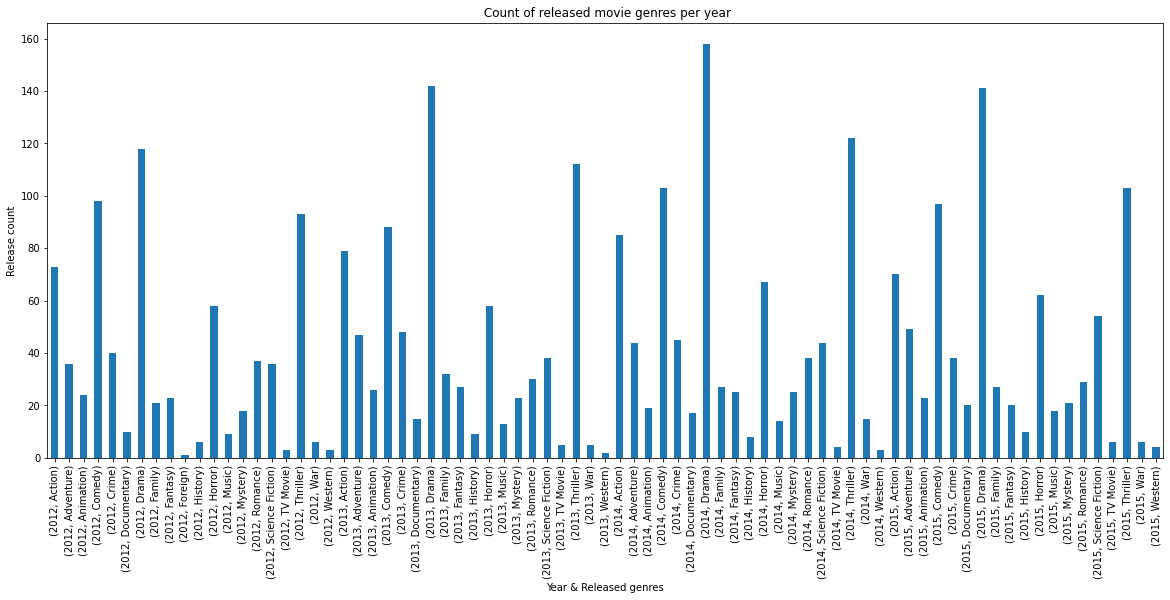

In [42]:
# Ploting the released genres per year for better observation

genres_per_year_counts.plot(kind="bar", figsize=(20,8))
#genres_per_year_counts.plot(kind="barh", figsize=(10,30));

plt.xlabel("Year & Released genres")
plt.ylabel("Release count")
plt.title(" Count of released movie genres per year");

Looking at the chart, we can observe that in recent years, the genres that stand out the most each year are :
* Comedy
* Drama
* Thriller

We will orient our investigation toward those 03 genres.

In [43]:
# Genres of movie we have
df["genres"].unique()

array(['Action', 'Adventure', 'Science Fiction', 'Thriller', 'Fantasy',
       'Crime', 'Western', 'Drama', 'Family', 'Animation', 'Comedy',
       'Mystery', 'Romance', 'War', 'History', 'Music', 'Horror',
       'Documentary', 'TV Movie', 'Foreign'], dtype=object)

In [44]:
# Targeted genres of movie
targeted_genres = ["Comedy","Drama","Thriller"]
targeted_genres

['Comedy', 'Drama', 'Thriller']

Let us observe the evolution of production of our targeted genres over the years.

In [45]:
analyze_from = max_year - 10
analyze_from

2005.0

In [46]:
target_genres_evolution = df.query(" genres in {} &  release_year >= {} ".format(targeted_genres,analyze_from)) \
                                .groupby(["genres","release_year"]) \
                                .count()
target_genres_evolution                             

id  imdb_id  popularity  budget  revenue  \
genres   release_year                                              
Comedy   2005           89       89          89      89       89   
         2006          103      103         103     103      103   
         2007           87       87          87      87       87   
         2008           96       96          96      96       96   
         2009          111      111         111     111      111   
         2010           97       97          97      97       97   
         2011          100      100         100     100      100   
         2012           98       98          98      98       98   
         2013           88       88          88      88       88   
         2014          103      103         103     103      103   
         2015           97       97          97      97       97   
Drama    2005          120      120         120     120      120   
         2006          131      131         131     131      131   
         2007          124      124         124     124      124   
         2008          121      121         121     121      121   
         2009          130      130         130     130      130   
         2010          126      126         126     126      126   
         2011          128      128         128     128      128   
         2012          118      118         118     118      118   
         2013          142      142         142     142      142   
         2014          158      158         158     158      158   
         2015          141      141         141     141      141   
Thriller 2005           71       71          71      71       71   
         2006           83       83          83      83       83   
         2007           86       86          86      86       86   
         2008           74       74          74      74       74   
         2009           98       98          98      98       98   
         2010           87       87          87      87       87   
         2011           98       98          98      98       98   
         2012           93       93          93      93       93   
         2013          112      112         112     112      112   
         2014          122      122         122     122      122   
         2015          103      103         103     103      103   

                       original_title  cast  director  tagline  keywords  \
genres   release_year                                                      
Comedy   2005                      89    89        89       89        89   
         2006                     103   103       103      103       103   
         2007                      87    87        87       87        87   
         2008                      96    96        96       96        96   
         2009                     111   111       111      111       111   
         2010                      97    97        97       97        97   
         2011                     100   100       100      100       100   
         2012                      98    98        98       98        98   
         2013                      88    88        88       88        88   
         2014                     103   103       103      103       103   
         2015                      97    97        97       97        97   
Drama    2005                     120   120       120      120       120   
         2006                     131   131       131      131       131   
         2007                     124   124       124      124       124   
         2008                     121   121       121      121       121   
         2009                     130   130       130      130       130   
         2010                     126   126       126      126       126   
         2011                     128   128       128      128       128   
         2012                     118   118       118      118       118   
         2013                     142   142    

In [47]:
target_genres_evolution = target_genres_evolution.iloc[:,1]
target_genres_evolution

genres    release_year
Comedy    2005             89
          2006            103
          2007             87
          2008             96
          2009            111
          2010             97
          2011            100
          2012             98
          2013             88
          2014            103
          2015             97
Drama     2005            120
          2006            131
          2007            124
          2008            121
          2009            130
          2010            126
          2011            128
          2012            118
          2013            142
          2014            158
          2015            141
Thriller  2005             71
          2006             83
          2007             86
          2008             74
          2009             98
          2010             87
          2011             98
          2012             93
          2013            112
          2014            122
          2015   

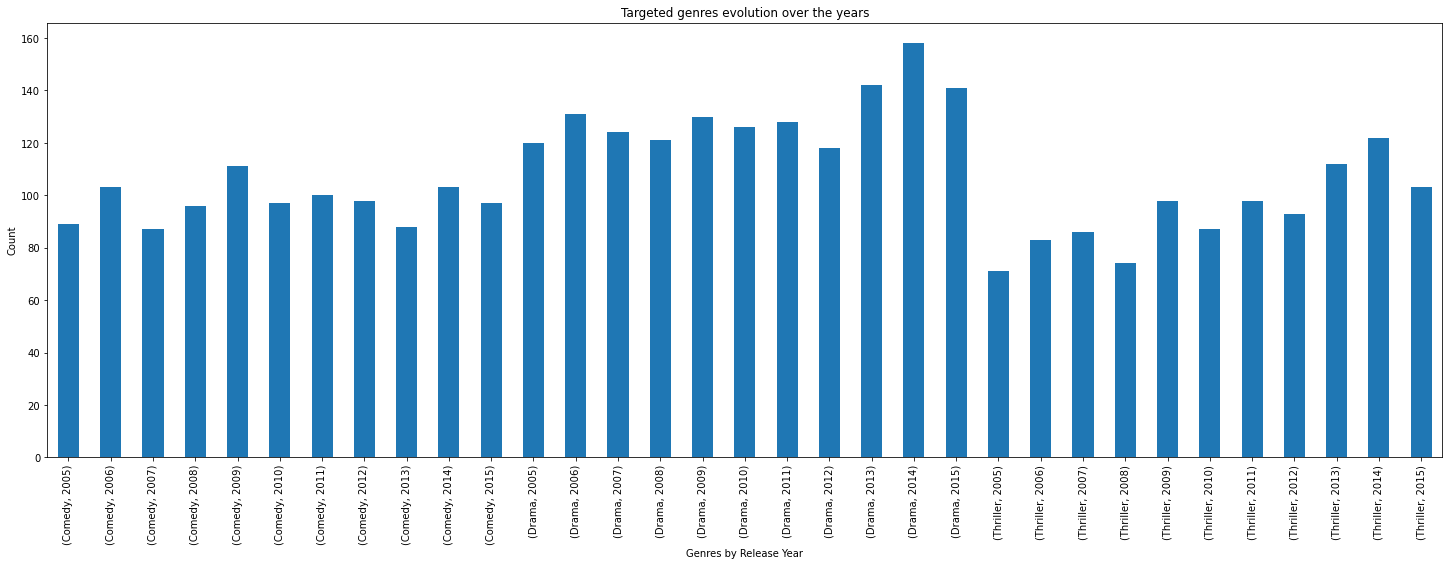

In [48]:
target_genres_evolution.plot(kind="bar",figsize=(25,8));

plt.ylabel("Count")
plt.xlabel("Genres by Release Year")
plt.title("Targeted genres evolution over the years");

TODO : make the color of the bar change for each genre (purple for Comedy, red for Thriller, pink for Drama).    
*Note : Dear Reviewer, please advise me a link/ressource that will teach me how to do this.*

Despite the fact that it is not easy to gain insight from the abobe plot since all the bars are blue in color, we can still use it as reference to make a better plot.

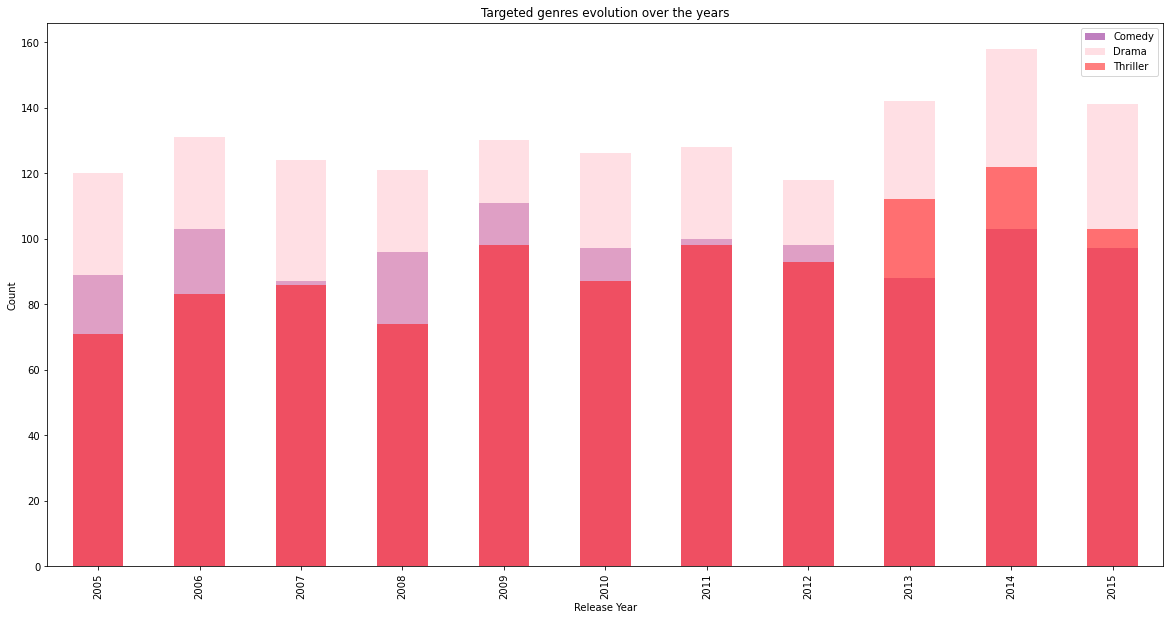

In [49]:
#fig,ax=plt.subplots()

fig,ax = plt.subplots(figsize=(20,10))

df.query(" genres == {} &  release_year >= {} ".format("'Comedy'",analyze_from)) \
                                .groupby(["genres","release_year"]) \
                                .count().iloc[:,1] \
                                .plot(kind="bar", alpha=.5, color="purple", label="Comedy")

df.query(" genres == {} &  release_year >= {} ".format("'Drama'",analyze_from)) \
                                .groupby(["genres","release_year"]) \
                                .count().iloc[:,1] \
                                .plot(kind="bar", alpha=.5, color="pink", label="Drama")

df.query(" genres == {} &  release_year >= {} ".format("'Thriller'",analyze_from)) \
                                .groupby(["genres","release_year"]) \
                                .count().iloc[:,1] \
                                .plot(kind="bar", alpha=.5, color="red", label="Thriller")

ax.set_xticklabels(range(2005,2016))

plt.ylabel("Count")
plt.xlabel("Release Year")
plt.title("Targeted genres evolution over the years")

plt.legend();

Looking at the chart, we can see that from 2005 to 2015 :
1. The minimum amount of Drama produced is superior to the maximum amount of Comedy and Thriller
2. The production of the Comedy genre has been fluctuating over the years, while the production of Drama appear to be more stable with some slight fluctuations    
3. The production of Thriller started small, then keep going up stably.  
4. Overall, the Drama genre appears to be more produced compared to the other genres.
    
We will later evaluate the revenue of each our targeted genres, in order to confirm which one we will focus on.

### Between the genres of movies on trend, what is the correlation between them and revenue ?    
We will explore the relationship between each genre and the revenue. The goal is to choose which genre of movie to invest on.

In order to make our work easier, we will drop all genres except those that are of interest to us.

In [50]:
targeted_genres

['Comedy', 'Drama', 'Thriller']

In [51]:
targeted_genres_df = df.query(" genres in {} and release_year >= {}".format(targeted_genres,analyze_from))
targeted_genres_df.head(3).T

,3,7,10
id,135397,76341,262500
imdb_id,tt0369610,tt1392190,tt2908446
popularity,32.985763,28.419936,13.112507
budget,150000000,150000000,110000000
revenue,1513528810,378436354,295238201
original_title,Jurassic World,Mad Max: Fury Road,Insurgent
cast,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,Shailene Woodley|Theo James|Kate Winslet|Ansel...
director,Colin Trevorrow,George Miller,Robert Schwentke
tagline,The park is open.,What a Lovely Day.,One Choice Can Destroy You
keywords,monster|dna|tyrannosaurus rex|velociraptor|island,future|chase|post-apocalyptic|dystopia|australia,based on novel|revolution|dystopia|sequel|dyst...


In [52]:
# Looking at how much sample we have
targeted_genres_df.shape

(3535, 20)

In [53]:
# Confirming the genres we have (in order to be sure of not having error)
targeted_genres_df["genres"].unique()

array(['Thriller', 'Drama', 'Comedy'], dtype=object)

In [54]:
# Let us undestand the distribution of the revenue
targeted_genres_df.describe()["revenue"]

count    3.535000e+03
mean     5.439440e+07
std      1.228452e+08
min      0.000000e+00
25%      0.000000e+00
50%      2.455831e+06
75%      5.501962e+07
max      1.513529e+09
Name: revenue, dtype: float64

25% of the produced movies generated no revenue. We should investigate why.

In [55]:
# Retrieving the movies with no revenue in our targeted genres
no_revenue_df = targeted_genres_df.query("revenue==0")
no_revenue_df.head(3).T

,145,147,199
id,265208,265208,334074
imdb_id,tt2231253,tt2231253,tt3247714
popularity,2.93234,2.93234,2.331636
budget,30000000,30000000,20000000
revenue,0,0,0
original_title,Wild Card,Wild Card,Survivor
cast,Jason Statham|Michael Angarano|Milo Ventimigli...,Jason Statham|Michael Angarano|Milo Ventimigli...,Pierce Brosnan|Milla Jovovich|Dylan McDermott|...
director,Simon West,Simon West,James McTeigue
tagline,Never bet against a man with a killer hand.,Never bet against a man with a killer hand.,His Next Target is Now Hunting Him
keywords,gambling|bodyguard|remake,gambling|bodyguard|remake,new year's eve|fire|showdown|terrorist|embassy


In [56]:
# Number of movies with no revenue in our targeted genres
no_revenue_df["id"].nunique()

1034

In [57]:
# Movies with no revenue in our targeted genres
no_revenue_df["original_title"].unique()

array(['Wild Card', 'Survivor', 'Me and Earl and the Dying Girl', ...,
       'Steel Trap', 'Margot at the Wedding', 'Rocket Science'],
      dtype=object)

A quick search over Google on some of those movies show that they have generated revenue as of today. So we can assume that at the time this dataset was compiled, those movies were just released, and thus have yet to be sold. But we will still observe the years over which those movies were release in order to confirm our hypothesis (all of them should be released at 2015, the last year of our dataset).  

In [58]:
# Looking at the release year
no_revenue_df["release_year"].unique()

array([2015, 2014, 2009, 2010, 2008, 2011, 2012, 2013, 2005, 2006, 2007],
      dtype=int64)

It is weird that the release years span over 2017 to 2015. But since our search over the net confirmed those movies generated revenues, we can still maintain our assumption there is a reason that explain why they have no revenue in our dataset, i.e. not being put to sale immediatly after being released. So in order to have a clear and comprehensive analysis, we will not consider them in the next stage of work.

In [59]:
targeted_genres_df.shape

(3535, 20)

In [60]:
# Dropping movies with no revenue
targeted_genres_with_revenue_df = targeted_genres_df.drop(no_revenue_df.index, axis=0)
targeted_genres_with_revenue_df.shape

(2166, 20)

In [61]:
# Total revenue generated by each genre in recent years
targeted_genres_with_revenue_df.groupby("genres").sum()["revenue"]

genres
Comedy      70216803556
Drama       63388784059
Thriller    58678601275
Name: revenue, dtype: int64

In [62]:
# Mean revenue geneated by each genre in recent years
targeted_genres_with_revenue_df.groupby("genres").mean()["revenue"]

genres
Comedy      1.035646e+08
Drama       7.035381e+07
Thriller    9.996355e+07
Name: revenue, dtype: float64

Comedy generated more total revenue in recent years than Drama.       
But looking at the mean revenue, we can see that Drama seems a more interesting genre to invest on because of its high revenue.     
As for Thriller, it generated the highest mean revenue.

So far, we can summarize that :
1. The most produced genre is Drama, followed by Comedy then Thriller
2. The genre with the highest mean revenue is Thriller, followed by Drama then Comedy.

From the above two points, we can see that :    
1. Producing Drama movie appears to be a more certain/stable investment :     
    * There are many produced monvies in that category, which show that it interest a great segment of the population.
    * There is a corresponding high revenue for that category.
    * The mean of that category is not far from its sum, which shows that each movie produced its fair amount of revenue.
2. Producing Thriller movie appears to have some constraints :
    * The fact that Thriller genres is the least produced genre shows us that there seems to be more constraints (maybe technicals/financials/time...) in producing those type of movies.
    * It is not easy to produce a Thriller movie, but we are sure that it may generate high revenue if produced successfully.
3. The total amount of Comedy revenue is in the 70 millions, while the mean revenue is in 0.1 million; this means that :
    * There are a great number of Comedy movies which generated too little revenue
    * It is not easy to make a good Comedy that will please the population.
    
        
Looking at those points, we can conclude that producing Drama is a good investment for us. Thriller is also a good choice, although is appear more complicated to be produced.

In [63]:
choosen_genre = "Drama"
choosen_genre

'Drama'

### What is the minimum amount of money to invest in our choosen genre in order to have the highest possible revenue ?

We are trying to understand the minimum amount of money to invest in order to generate high revenue.

In [64]:
choosen_genre

'Drama'

In [65]:
df_drama = targeted_genres_df.query("genres== '{}'".format(choosen_genre))
df_drama.head(3).T

,19,26,43
id,281957,286217,264660
imdb_id,tt1663202,tt3659388,tt0470752
popularity,9.1107,7.6674,6.118847
budget,135000000,108000000,15000000
revenue,532950503,595380321,36869414
original_title,The Revenant,The Martian,Ex Machina
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,Domhnall Gleeson|Alicia Vikander|Oscar Isaac|S...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Ridley Scott,Alex Garland
tagline,"(n. One who has returned, as if from the dead.)",Bring Him Home,There is nothing more human than the will to s...
keywords,father-son relationship|rape|based on novel|mo...,based on novel|mars|nasa|isolation|botanist,dancing|artificial intelligence|helicopter|dis...


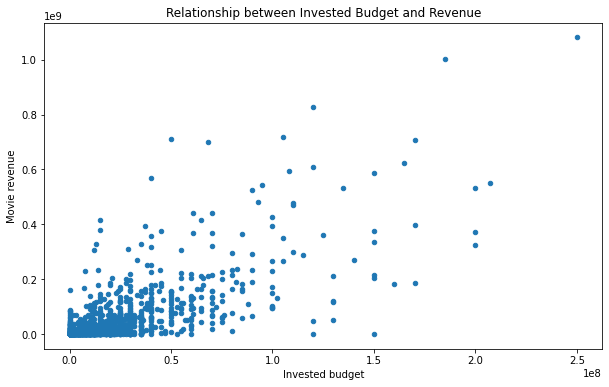

In [66]:
# Let's understand the relationship between budget and revenue
df_drama.plot(x="budget",y="revenue",kind="scatter", figsize=(10,6))

plt.xlabel("Invested budget")
plt.ylabel("Movie revenue")
plt.title("Relationship between Invested Budget and Revenue");

This plot tell us two things :
* There is a linear relationship between invested budget and generated revenue
* Increasing the movie budget will generate a higher revenue.  

In [67]:
# mean revenue of drama genres
mean_revenue = df_drama.loc[:,"revenue"].mean()
mean_revenue

44050579.610145934

Machine/Deep Learning algorithms and Inferential Statistics technics will allow us to determine which exact amount of budget to invest in order to obtain a given amount of revenue. This is outside the scope of our current analysis, so we will refer to the mean budget invested in Drama genre and use it as the minimum amount of budget required to have a good Drama movie.

### What is the companies that are best at the genre of movie that is of interest to us ?
Our goal here is to choose wich company to choose as the productor of our movie. We will refer to 03 criterias here :
* The total number of Drama movies produced by each company
* The total amount of budget used to produced Drama movies (we can infer from this the level of trust and ability to manage budget each company have) 
* The total amount of revenue generated by each company

We will keep in mind that some companies work together on some movies. So what we are searching for is the company that is related to the most interesting numbers, assuming that the said company will already have its business network to have the job properly done for us.

**Analyzing the number of Drama movies produced by the companies**     
This will help us understand how much active each company is in the Drama genre.

In [68]:
df_drama.head(3).T

,19,26,43
id,281957,286217,264660
imdb_id,tt1663202,tt3659388,tt0470752
popularity,9.1107,7.6674,6.118847
budget,135000000,108000000,15000000
revenue,532950503,595380321,36869414
original_title,The Revenant,The Martian,Ex Machina
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,Domhnall Gleeson|Alicia Vikander|Oscar Isaac|S...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Ridley Scott,Alex Garland
tagline,"(n. One who has returned, as if from the dead.)",Bring Him Home,There is nothing more human than the will to s...
keywords,father-son relationship|rape|based on novel|mo...,based on novel|mars|nasa|isolation|botanist,dancing|artificial intelligence|helicopter|dis...


We will need to remove the pipes from `production_companies` feature in order to make our analysis.

In [69]:
# Shape before pipes removal
df_drama.shape

(1439, 20)

In [70]:
# Removal of pipes in production_companies
to_unpipes =["production_companies"]  #["cast","keywords","genres","production_companies"]

df_drama = unpipe_features(df=df_drama, features=to_unpipes, separator="|")
df_drama.head(3).T

****************************************************************************************************
Working on feature : production_companies 
Shape of dataset before processing : (1439, 20)
................................................................
Processing row index : 19 
------------------------------------------
Processing row index : 26 
------------------------------------------
Processing row index : 43 
------------------------------------------
Processing row index : 52 
------------------------------------------
Processing row index : 64 
------------------------------------------
Processing row index : 74 
------------------------------------------
Processing row index : 76 
------------------------------------------
Processing row index : 78 
------------------------------------------
Processing row index : 81 
------------------------------------------
Processing row index : 88 
------------------------------------------
Processing row index : 95 
----------------

<ipython-input-3-c2957a6bffe6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_col] = df[feature]



------------------------------------------
Processing row index : 1843 
------------------------------------------
Processing row index : 1848 
------------------------------------------
Processing row index : 1852 
------------------------------------------
Processing row index : 1859 
------------------------------------------
Processing row index : 1880 
------------------------------------------
Processing row index : 1884 
------------------------------------------
Processing row index : 1889 
------------------------------------------
Processing row index : 1891 
------------------------------------------
Processing row index : 1914 
------------------------------------------
Processing row index : 1918 
------------------------------------------
Processing row index : 1926 
------------------------------------------
Processing row index : 1940 
------------------------------------------
Processing row index : 1945 
------------------------------------------
Processing row index

------------------------------------------
Processing row index : 3252 
------------------------------------------
Processing row index : 3257 
------------------------------------------
Processing row index : 3263 
------------------------------------------
Processing row index : 3277 
------------------------------------------
Processing row index : 3278 
------------------------------------------
Processing row index : 3290 
------------------------------------------
Processing row index : 3292 
------------------------------------------
Processing row index : 4177 
------------------------------------------
Processing row index : 4193 
------------------------------------------
Processing row index : 4207 
------------------------------------------
Processing row index : 4214 
------------------------------------------
Processing row index : 4235 
------------------------------------------
Processing row index : 4237 
------------------------------------------
Processing row index 

Processing row index : 6864 
------------------------------------------
Processing row index : 6868 
------------------------------------------
Processing row index : 6870 
------------------------------------------
Processing row index : 6882 
------------------------------------------
Processing row index : 6885 
------------------------------------------
Processing row index : 6888 
------------------------------------------
Processing row index : 6894 
------------------------------------------
Processing row index : 6903 
------------------------------------------
Processing row index : 6905 
------------------------------------------
Processing row index : 6906 
------------------------------------------
Processing row index : 6924 
------------------------------------------
Processing row index : 6927 
------------------------------------------
Processing row index : 6931 
------------------------------------------
Processing row index : 6932 
-----------------------------------

Processing row index : 9649 
------------------------------------------
Processing row index : 9652 
------------------------------------------
Processing row index : 9655 
------------------------------------------
Processing row index : 9659 
------------------------------------------
Processing row index : 9663 
------------------------------------------
Processing row index : 9668 
------------------------------------------
Processing row index : 9671 
------------------------------------------
Processing row index : 9673 
------------------------------------------
Processing row index : 9677 
------------------------------------------
Processing row index : 9678 
------------------------------------------
Processing row index : 9686 
------------------------------------------
Processing row index : 9687 
------------------------------------------
Processing row index : 9689 
------------------------------------------
Processing row index : 9691 
-----------------------------------

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [71]:
df_drama.head(3).T

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [72]:
# Shape afeter pipes removal
df_drama.shape

(4323, 20)

In [73]:
# Let us take a look at the list of production companies
df_drama["production_companies"].unique()

array(['Regency Enterprises', 'Appian Way', 'CatchPlay', ...,
       'W B I Films', 'Rocket Science Inc.', 'Duly Noted'], dtype=object)

In [74]:
# Let us see the number of production companies we have
df_drama["production_companies"].nunique()

2143

In [75]:
# Total number of Drama movies produced by each company
productions_count = df_drama.groupby(["production_companies"]).count().loc[:,"imdb_id"]
productions_count

production_companies
1019 Entertainment                   1
10th Hole Productions                1
11:11 Mediaworks                     1
1492 Pictures                        2
185 Trax                             1
                                    ..
Zweites Deutsches Fernsehen (ZDF)    1
amber entertainment                  1
iDeal Partners Film Fund             3
icon                                 1
uFilm                                2
Name: imdb_id, Length: 2143, dtype: int64

In [76]:
# Let us see the scope of movies production count, to understand the gap between the best and worst companies
min(productions_count), max(productions_count)

(1, 62)

In [77]:
# Taking a look at the distribution of movies production count, to have a better understanding of the repartition of 
#  the companies activities
productions_count.describe()

count    2143.000000
mean        2.017266
std         3.409793
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        62.000000
Name: imdb_id, dtype: float64

We can see that there is a large gap between the companies. It made wondering if our database is uptodate and if we should go back and recollect datas.     
For this report, we will assume that the large difference in productivity is related to the fact that the majority of companies produce other genres of movie apart from Drama, while the rest focus on producing Drama movie. We will limit our choices to the companies which focus/specialize on Drama genre.

In [78]:
# Getting the mean of Drama genre production count, so that we us it as reference to select the best companies
mean_produced_dramas = productions_count.mean()
mean_produced_dramas

2.017265515632291

In [79]:
# Total number of Drama movies produced by each of the best companies
productions_count = df_drama.groupby(["production_companies"]).count() \
                            .query("imdb_id > {}".format(mean_produced_dramas))\
                            .loc[:,"imdb_id"]
productions_count

production_companies
1984 Private Defense Contractors     3
20th Century Fox                     7
21 Laps Entertainment                3
2929 Productions                    10
3 Arts Entertainment                 4
                                    ..
Yari Film Group                      5
Yucaipa Films                        3
Zentropa Entertainments              8
Zephyr Films                         4
iDeal Partners Film Fund             3
Name: imdb_id, Length: 334, dtype: int64

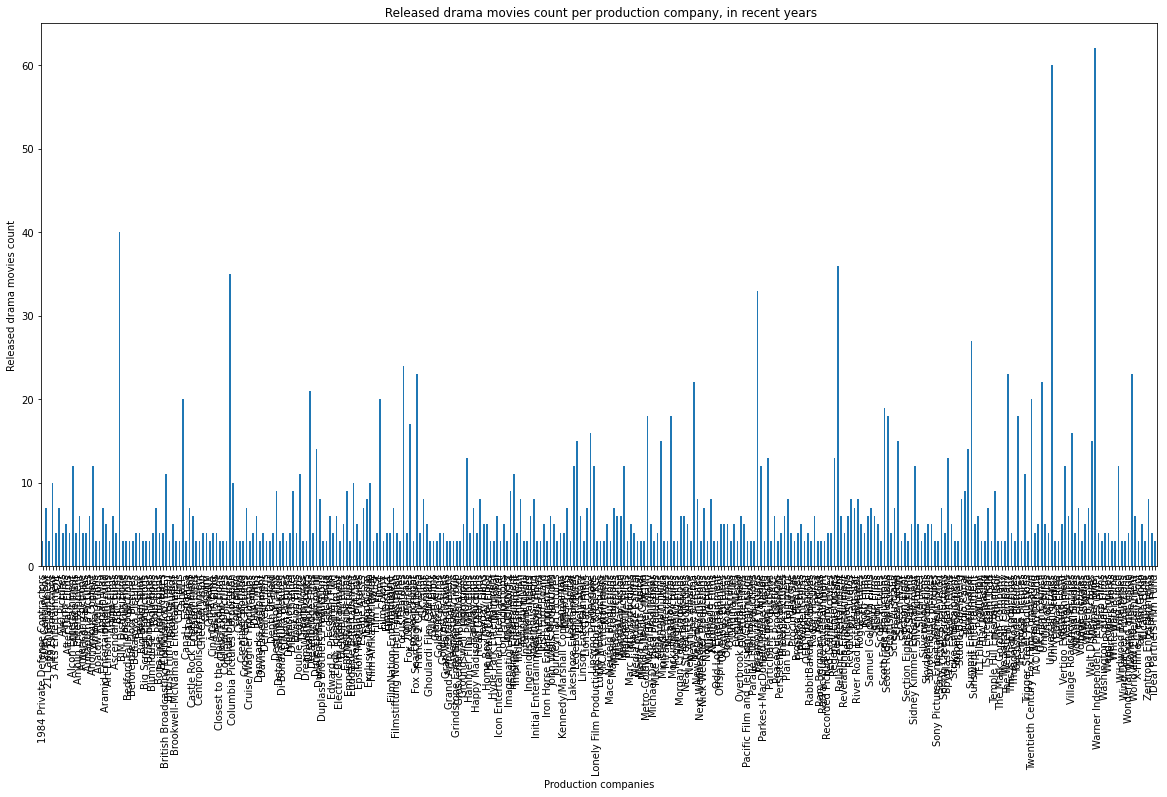

In [80]:
# Let us plot the total number of Drama movies, to help ourselves through somes visualization
productions_count.plot(kind="bar",figsize=(20,10))

plt.xlabel("Production companies")
plt.ylabel("Released drama movies count")
plt.title(" Released drama movies count per production company, in recent years");

Our chart is too crowded to obtain useful informations. But we can still observe that :
* There are many companies that match our criteria.
* Many companies have produced over 20 movies.

So we will use 20 as a reference to select the best companies for us.

In [81]:
# Minimum number a company has to have produced in order to be considered
min_productions_count = 20

In [82]:
# Total number of Drama movies produced by each of the best companies
productions_count = df_drama.groupby(["production_companies"]).count() \
                            .query("imdb_id > {}".format(min_productions_count))\
                            .loc[:,"imdb_id"]
productions_count

production_companies
BBC Films                   40
Columbia Pictures           35
DreamWorks SKG              21
Focus Features              24
Fox Searchlight Pictures    23
New Line Cinema             22
Paramount Pictures          33
Relativity Media            36
Summit Entertainment        27
The Weinstein Company       23
UK Film Council             22
Universal Pictures          60
Warner Bros.                62
Working Title Films         23
Name: imdb_id, dtype: int64

This reduced list is much more better for us. We will help ourself by a chart to compare the companies activities.

In [83]:
# Ordering the production count in descending order
productions_count = productions_count.sort_values(ascending=False)
productions_count

production_companies
Warner Bros.                62
Universal Pictures          60
BBC Films                   40
Relativity Media            36
Columbia Pictures           35
Paramount Pictures          33
Summit Entertainment        27
Focus Features              24
Fox Searchlight Pictures    23
The Weinstein Company       23
Working Title Films         23
New Line Cinema             22
UK Film Council             22
DreamWorks SKG              21
Name: imdb_id, dtype: int64

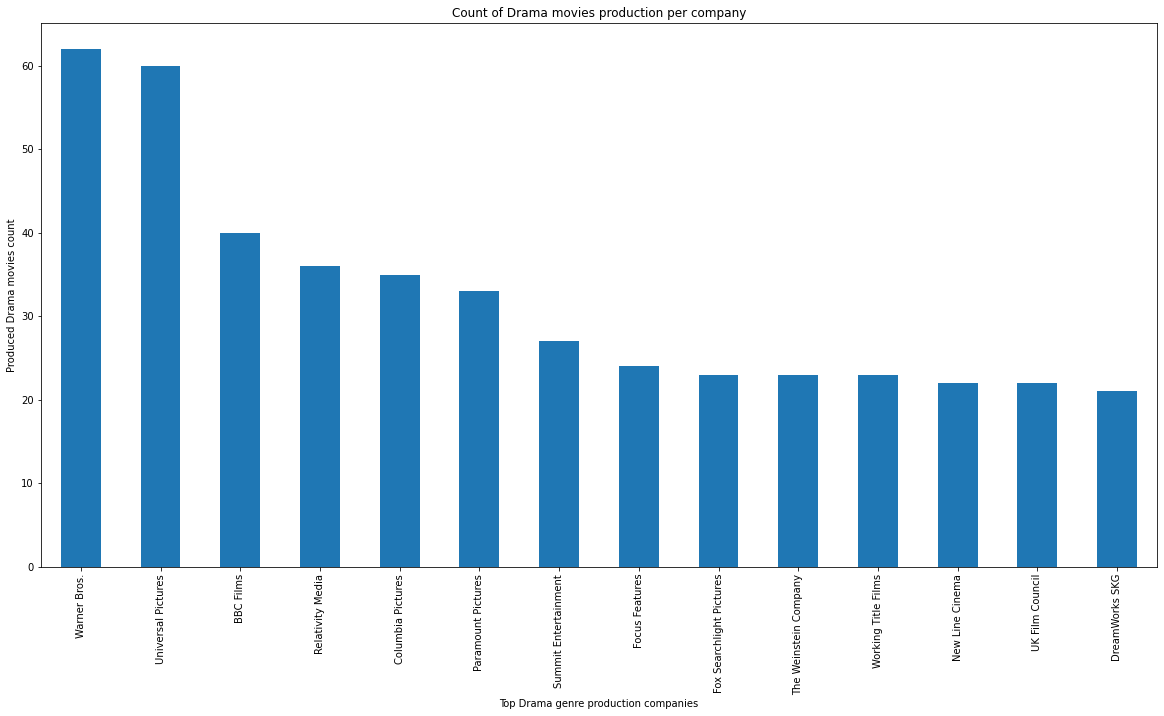

In [84]:
# Plot the total number of Drama movies produced by each of the best companies
productions_count.plot(kind="bar",figsize=(20,10))

plt.xlabel("Top Drama genre production companies")
plt.ylabel("Produced Drama movies count")
plt.title("Count of Drama movies production per company");

Two companies catch our attention : 
1. Warner Bros
1. Universal Pictures

We can still consider the next 3 best companies, since the number of Drama movies produced is not our only choosing criteria :
1. BBC Films
1. Relativity Media
1. Columbia Pictures
1. Paramount Pictures                       

We are adding `Paramount Pictures` because its values is close to `Columbia Pictures`, so other factors may bring us later to prefer it.

**Analyzing the total amount of budget used to produced Drama movies**     

(we can infer from this the level of trust and ability to manage budget each company have)

This will help us infer :
* The standard of movie each company work on, assuming that the better the standard, the higher the needed budget
* How much the clients trust each company, because the higher the trust, the higher the amount of money one is willing to entrust

In [85]:
df_drama.head(3).T

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [86]:
# Total amount of budget used in the production of Drama movies by each company
budgets_sum = df_drama.groupby(["production_companies"]).sum().loc[:,"budget"] \
                       .sort_values(ascending=False)
budgets_sum

production_companies
Warner Bros.                     4105600000
Universal Pictures               2834000000
Paramount Pictures               2003000001
Columbia Pictures                1851795000
Relativity Media                 1748000000
                                    ...    
Googly Films                              0
Good Dick                                 0
Goldcrest Films International             0
Goalpost Pictures                         0
Lama Productions                          0
Name: budget, Length: 2143, dtype: int64

In [87]:
# Observing the distribution of the total amount budget managed by each Drama company
budgets_sum.describe()

count    2.143000e+03
mean     4.386400e+07
std      1.579376e+08
min      0.000000e+00
25%      0.000000e+00
50%      7.000000e+06
75%      3.200000e+07
max      4.105600e+09
Name: budget, dtype: float64

There are companies which have never managed budget; we will assume that their data are not uptodate in our database, and focus on those who have budget data.     
There is a large gap between the 25% tile, the 50% tile, the 75% tile of our quartile and the max value. This should help us take notice of the most trusted companies easily. Once again, we will work with the mean amount of budget as a reference to identify the most/less trusted companies in our database. 

In [88]:
# Getting the mean of the total budget managed by companies, so that we use if as reference to identify the 
#    most trusted ones
mean_managed_budgets = budgets_sum.mean()
mean_managed_budgets

43863995.0275315

In [89]:
# Total amount of budget used in the production of Drama movies by each of the best companies
budgets_sum = df_drama.groupby(["production_companies"]).sum() \
                      .query(" budget > {} ".format(mean_managed_budgets)) \
                      .loc[:,"budget"]             
                      #.sort_values(ascending=False)
budgets_sum

production_companies
1492 Pictures                        65000000
1984 Private Defense Contractors    109000000
20th Century Fox                    283000000
21 Laps Entertainment               132300000
2929 Productions                    156700000
                                      ...    
Zadan / Meron Productions            45000000
Zaftig Films                         50100000
Zanuck Company, The                  50000000
Zehnte Babelsberg                    70000000
Zephyr Films                         58500000
Name: budget, Length: 430, dtype: int64

In [90]:
# Looking at the number of companies which are considered the best
budgets_sum.shape

(430,)

In [91]:
# Ordering the budget sum in descending order
budgets_sum = budgets_sum.sort_values(ascending=False)
budgets_sum

production_companies
Warner Bros.                  4105600000
Universal Pictures            2834000000
Paramount Pictures            2003000001
Columbia Pictures             1851795000
Relativity Media              1748000000
                                 ...    
Senator International           45000000
Storyline Entertainment         45000000
Onda Entertainment              45000000
M6 Films                        45000000
Alberta Film Entertainment      44000000
Name: budget, Length: 430, dtype: int64

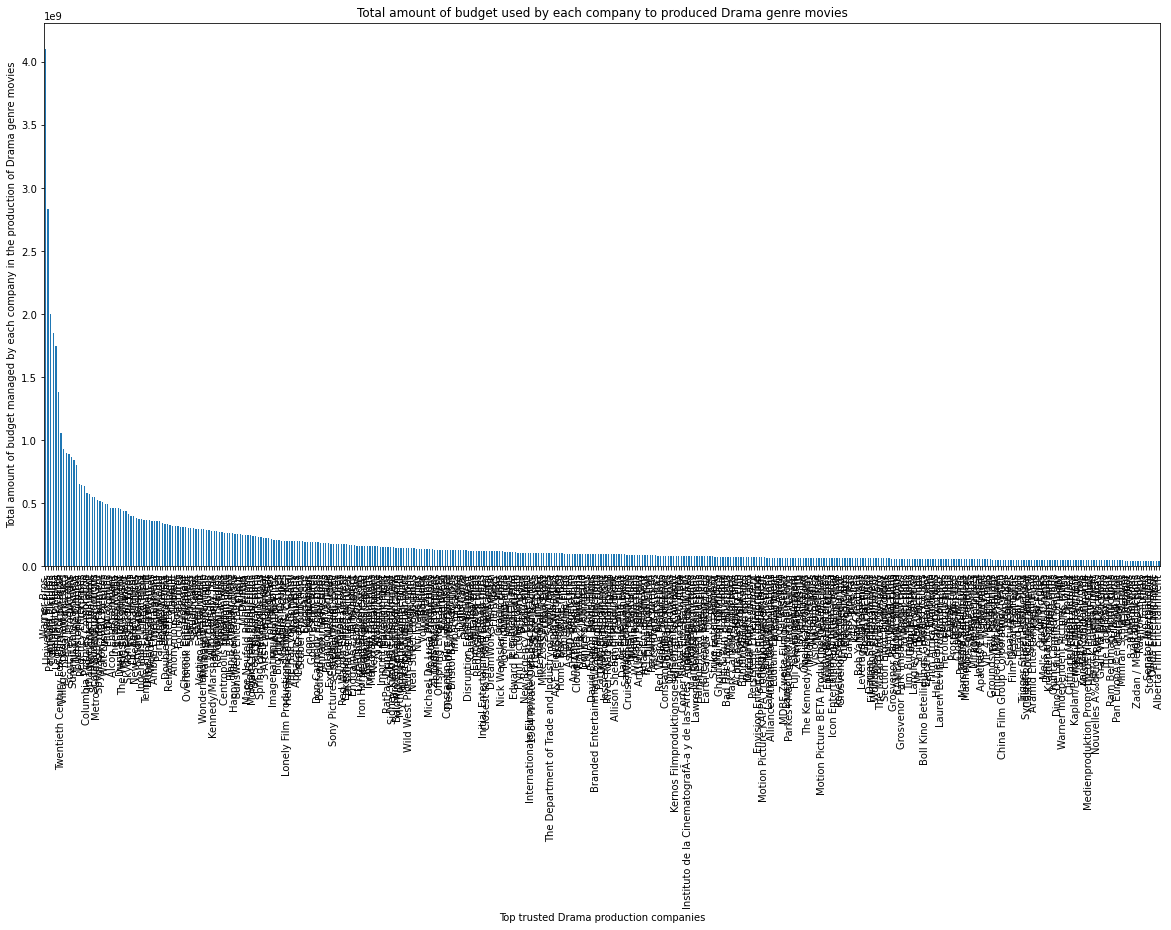

In [92]:
# Plot the total number of Drama movies produced by each of the best companies
budgets_sum.plot(kind="bar",figsize=(20,10))

plt.xlabel("Top trusted Drama production companies")
plt.ylabel("Total amount of budget managed by each company in the production of Drama genre movies")
plt.title("Total amount of budget used by each company to produced Drama genre movies");

Our chart is way too crowded to obtain useful informations. But we can still observe that :
* There are many companies that match our criteria.
* Many companies have managed budget over an amount of 0.5 1e9 .

So we will use 0.5 1e9 as a reference to select the most trusted companies.

In [93]:
min_budgets_sum = 0.5 * 1e9
min_budgets_sum

500000000.0

In [94]:
# Total amount of budget used in the production of Drama movies by each of the best companies
budgets_sum = df_drama.groupby(["production_companies"]).sum() \
                      .query(" budget > {} ".format(min_budgets_sum)) \
                      .loc[:,"budget"]             
                    
budgets_sum

production_companies
Columbia Pictures                         1851795000
Columbia Pictures Corporation              579500000
DreamWorks SKG                             901000000
Fox 2000 Pictures                          509000000
GK Films                                   636500000
Imagine Entertainment                      575000000
Legendary Pictures                        1385000000
Metro-Goldwyn-Mayer (MGM)                  523000000
New Line Cinema                            805000000
Paramount Pictures                        2003000001
Regency Enterprises                        648000000
Relativity Media                          1748000000
Scott Free Productions                     869545202
Scott Rudin Productions                    550665000
Spyglass Entertainment                     518000000
Summit Entertainment                       847160000
Syncopy                                    890000000
Touchstone Pictures                        654000000
Twentieth Century Fox Fil

We have an easier manageable list. We will order it to make it easy for observations and plots

In [95]:
# Ordering the budget sum in descending order
budgets_sum = budgets_sum.sort_values(ascending=False)
budgets_sum

production_companies
Warner Bros.                              4105600000
Universal Pictures                        2834000000
Paramount Pictures                        2003000001
Columbia Pictures                         1851795000
Relativity Media                          1748000000
Legendary Pictures                        1385000000
Twentieth Century Fox Film Corporation    1062000000
Village Roadshow Pictures                  932000000
DreamWorks SKG                             901000000
Syncopy                                    890000000
Scott Free Productions                     869545202
Summit Entertainment                       847160000
New Line Cinema                            805000000
Touchstone Pictures                        654000000
Regency Enterprises                        648000000
GK Films                                   636500000
Columbia Pictures Corporation              579500000
Imagine Entertainment                      575000000
Working Title Films      

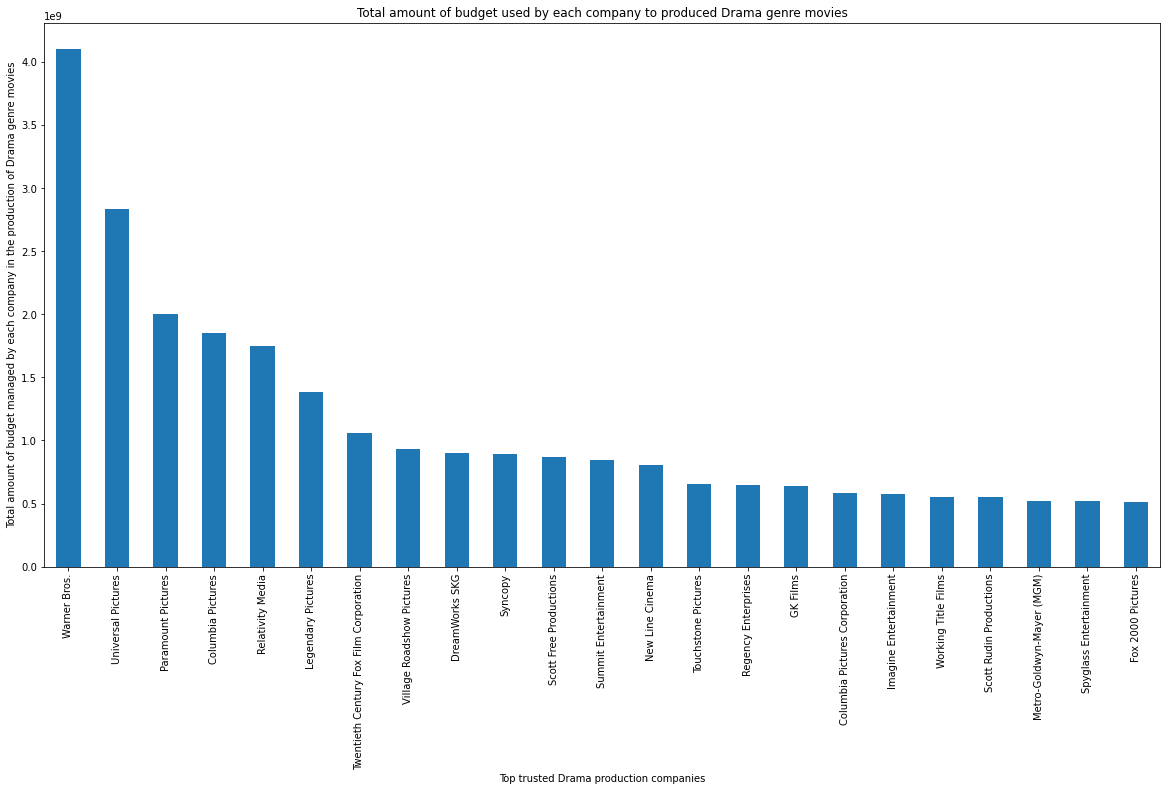

In [96]:
# Plot the total number of Drama movies produced by each of the best companies
budgets_sum.plot(kind="bar",figsize=(20,10))

plt.xlabel("Top trusted Drama production companies")
plt.ylabel("Total amount of budget managed by each company in the production of Drama genre movies")
plt.title("Total amount of budget used by each company to produced Drama genre movies");

Two companies catch our attention : 
1. Warner Bros
1. Universal Pictures        

They happen to also be part of the ones that produced the highest number of Drama movies.

We can notice that the next 3 trusted companies are also part of the top 5 productors of Drama movies, in term of movies count :
1. Paramount Pictures
1. Columbia Pictures
1. Relativity Media

It is good to notice that the order of these 3 companies is inversed to their order in the list of top 5 productors of Drama movies in term of movies count. We can see that they produce less movie, but use a total amount of higher budget; we can conclude that they tend to produce movies with high standard (assuming that the standard of a movie is related to the amount of budget required).

                       

We will take notice of `Warner Bros` and `Universal Pictures` because of their presence in the two list, being each time in the position of top 2 by a fair amount.

**Analyzing the total amount of revenue generated by each production company**     

This will help us infer the ability of each company to produce high revenue, and allegedly good movie. In that regard, we will not only analyze the total amount revenue generated, but also the proportion of generated revenue compared to the proportion of allocated budget; maybe we will find a dark horse, a company that is good but go unoticed so far.

In [97]:
df_drama.head(3).T

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [98]:
# Total amount of revenue produced by each company, and their total amount of corresponding budget 
revenues_budgets = df_drama.groupby(["production_companies"]).sum().loc[:,["revenue","budget"]]
revenues_budgets

,revenue,budget
production_companies,,
1019 Entertainment,2801508,2000000
10th Hole Productions,34705850,4000000
11:11 Mediaworks,119188334,25000000
1492 Pictures,155942744,65000000
185 Trax,0,4200000
...,...,...
Zweites Deutsches Fernsehen (ZDF),0,20000000
amber entertainment,1162635,0
iDeal Partners Film Fund,56404,4000000


In [99]:
# Getting the number of Drama movies produced by each company
movies_count_df = df_drama.groupby("production_companies").count().loc[:,["imdb_id"]]
movies_count_df.rename(columns={
    "imdb_id":"movies_count"
},inplace=True)
movies_count_df

,movies_count
production_companies,
1019 Entertainment,1
10th Hole Productions,1
11:11 Mediaworks,1
1492 Pictures,2
185 Trax,1
...,...
Zweites Deutsches Fernsehen (ZDF),1
amber entertainment,1
iDeal Partners Film Fund,3


In [100]:
# Compiling each company stat

# reference : https://www.statology.org/pandas-merge-on-index/

companies_stats = revenues_budgets.join(movies_count_df)
companies_stats

,revenue,budget,movies_count
production_companies,,,
1019 Entertainment,2801508,2000000,1
10th Hole Productions,34705850,4000000,1
11:11 Mediaworks,119188334,25000000,1
1492 Pictures,155942744,65000000,2
185 Trax,0,4200000,1
...,...,...,...
Zweites Deutsches Fernsehen (ZDF),0,20000000,1
amber entertainment,1162635,0,1
iDeal Partners Film Fund,56404,4000000,3


In [101]:
# We will drop the companies where budget or revenue is 0, because their is probably not up to date in our database
companies_stats = companies_stats.query(" revenue!=0 & budget!=0 ")
companies_stats

,revenue,budget,movies_count
production_companies,,,
1019 Entertainment,2801508,2000000,1
10th Hole Productions,34705850,4000000,1
11:11 Mediaworks,119188334,25000000,1
1492 Pictures,155942744,65000000,2
1984 Private Defense Contractors,150161095,109000000,3
...,...,...,...
Zininsa Film Production,4040588,5000000,1
Zoetrope Argentina,113221,15000000,1
Zucker/Netter Productions,309208309,29000000,1


In [102]:
companies_stats["productivity_indice"] = companies_stats["revenue"] / companies_stats["budget"]
companies_stats

<ipython-input-102-2a48b3f196b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  companies_stats["productivity_indice"] = companies_stats["revenue"] / companies_stats["budget"]


,revenue,budget,movies_count,productivity_indice
production_companies,,,,
1019 Entertainment,2801508,2000000,1,1.400754
10th Hole Productions,34705850,4000000,1,8.676462
11:11 Mediaworks,119188334,25000000,1,4.767533
1492 Pictures,155942744,65000000,2,2.399119
1984 Private Defense Contractors,150161095,109000000,3,1.377625
...,...,...,...,...
Zininsa Film Production,4040588,5000000,1,0.808118
Zoetrope Argentina,113221,15000000,1,0.007548
Zucker/Netter Productions,309208309,29000000,1,10.662355


The higher the productivity indice, the higher the performance of the company with the allocated budget. Thus we will look at the companies that have the best productivity indices.

In [103]:
# Getting the mean of the productivity_indice, in order to use it as reference to select
#  companies with the best productivity indice
mean_prod_indice = companies_stats.loc[:,"productivity_indice"].mean()
mean_prod_indice

320.1550663296829

In [104]:
# Selecting the companies with the best productivity indice
best_companies = companies_stats.query(" productivity_indice > {} ".format(mean_prod_indice))
best_companies

,revenue,budget,movies_count,productivity_indice
production_companies,,,,
Lewis Gilbert Productions,2500000,93,1,26881.72043
Modern VideoFilm,2500000,93,1,26881.72043
Unison Films,985050,3,4,328350.00000


This result doesn't appear reliable, specialy the allocated budget. This show that we should :
* check if there is a mistake with the data collected for those three companies
* deal with outliers in our dataset.

In [105]:
# Looking at the productivity indice distribution
companies_stats.describe()["productivity_indice"]

count      1205.000000
mean        320.155066
std        9520.721410
min           0.000005
25%           0.660464
50%           1.723521
75%           3.108927
max      328350.000000
Name: productivity_indice, dtype: float64

A productivity indice of 328350 is too unreasonable. We can safely assume :
* There is something wrong with our data; in order to resolve it, we will consider those excess value as outliers and remove them from our analysis. 
* The value in the 75% tile seem more trusworthy.

Since dealing with outliers was not part of this course, and to save time, we will directly analyze the revenue, without considering the productivity indice anymore.

In [106]:
# Total amount of revenue produced by each Drama company
revenues_sum = df_drama.groupby(["production_companies"]).sum().loc[:,"revenue"] \
                       .sort_values(ascending=False)
revenues_sum

production_companies
Warner Bros.               11308480145
Universal Pictures          6572879289
Paramount Pictures          4835820356
Legendary Pictures          4493618973
Columbia Pictures           4431933801
                              ...     
Pukka Films                          0
EOS Entertainment                    0
Quantum Entertainment                0
Quickfire Films                      0
Kinowelt Filmproduktion              0
Name: revenue, Length: 2143, dtype: int64

We will only consider the best companies in our analysis. We will refer to the mean to determine the said best companies.

In [107]:
mean_generated_revenues = revenues_sum.mean()
mean_generated_revenues

110543405.70321979

In [108]:
# Total amount of revenue produced by each Drama company
revenues_sum = df_drama.groupby(["production_companies"]).sum() \
                        .query(" revenue > {} ".format(mean_generated_revenues)) \
                        .loc[:,"revenue"] \
                       .sort_values(ascending=False)
revenues_sum

production_companies
Warner Bros.                       11308480145
Universal Pictures                  6572879289
Paramount Pictures                  4835820356
Legendary Pictures                  4493618973
Columbia Pictures                   4431933801
                                      ...     
Essential Media & Entertainment      112544580
Wildgaze Films                       112527448
Worldview Entertainment              112413185
Art Linson Productions               112039766
Color Force                          111813966
Name: revenue, Length: 385, dtype: int64

In [109]:
revenues_sum.shape

(385,)

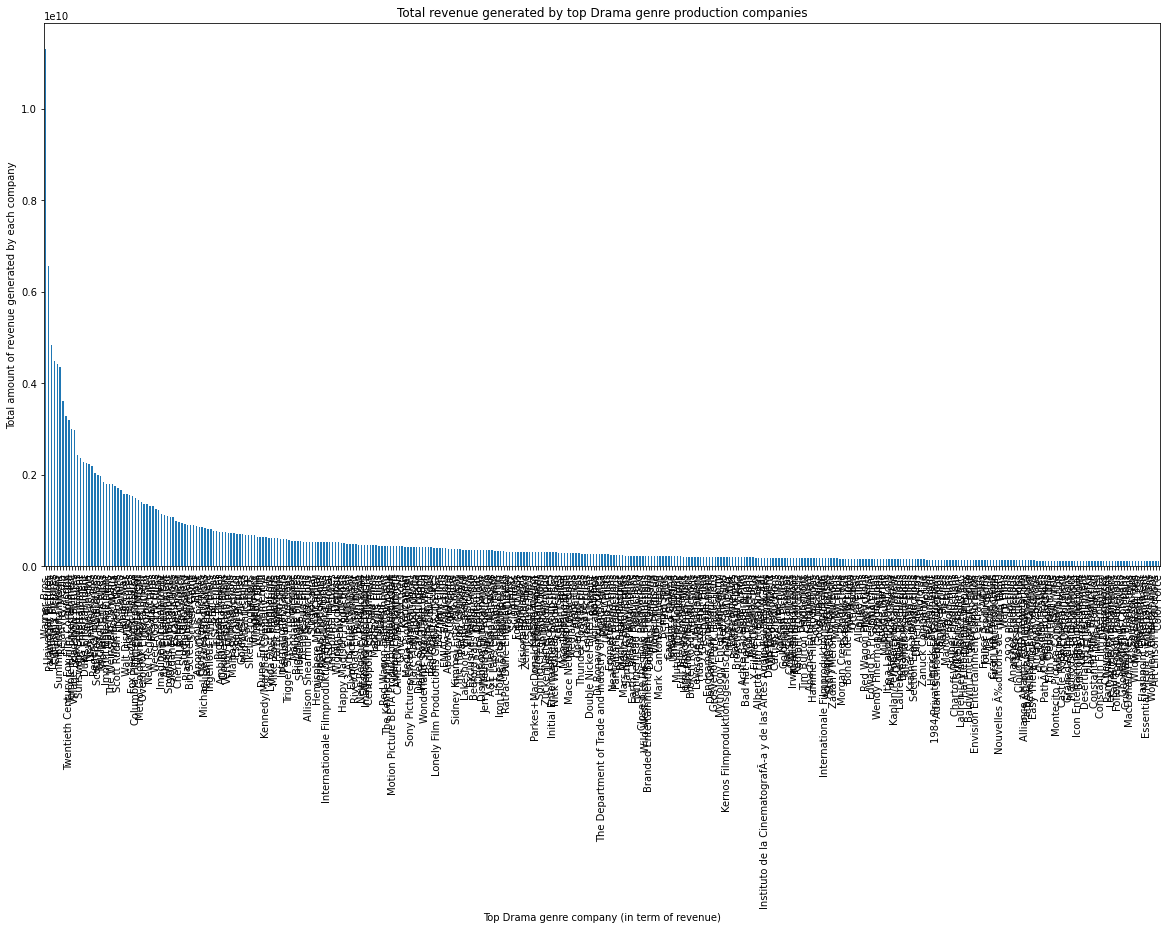

In [110]:
# Plot the total number of Drama movies produced by each of the best companies
revenues_sum.plot(kind="bar",figsize=(20,10))

plt.xlabel("Top Drama genre company (in term of revenue)")
plt.ylabel("Total amount of revenue generated by each company")
plt.title("Total revenue generated by top Drama genre production companies");

The charrt is too crowded, by we can still observe that many companies have generated a revenue of over 0.3 1e10. We will that amount as reference to select our best companies.

In [111]:
min_revenues_sum = 0.3 * 1e10
min_revenues_sum

3000000000.0

In [112]:
# Total amount of revenue produced by each Drama company
revenues_sum = df_drama.groupby(["production_companies"]).sum() \
                        .query(" revenue > {} ".format(min_revenues_sum)) \
                        .loc[:,"revenue"] \
                       .sort_values(ascending=False)
revenues_sum

production_companies
Warner Bros.                              11308480145
Universal Pictures                         6572879289
Paramount Pictures                         4835820356
Legendary Pictures                         4493618973
Columbia Pictures                          4431933801
Summit Entertainment                       4361673858
Relativity Media                           3607551987
Syncopy                                    3291649834
Twentieth Century Fox Film Corporation     3205540738
Temple Hill Entertainment                  3000164441
Name: revenue, dtype: int64

We now have a more manageable amount of company for plots and observations.

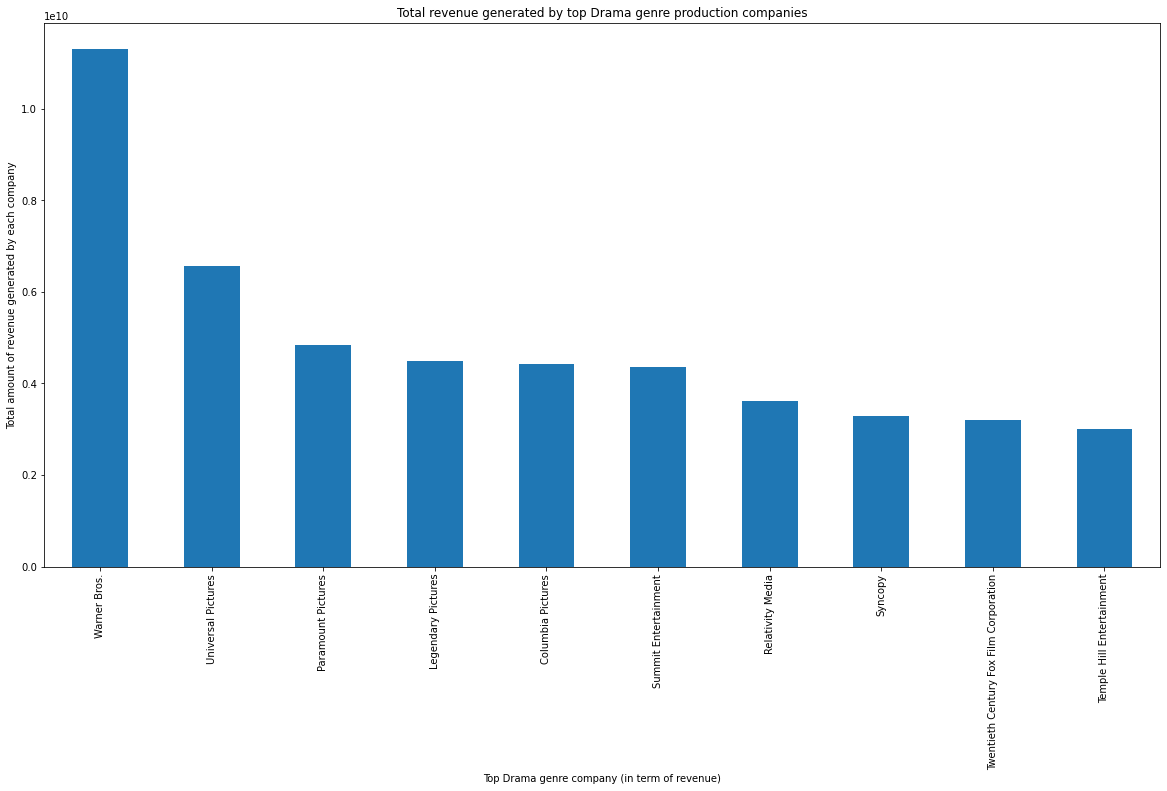

In [113]:
# Plot the amount of revenue produced by each of the best Drama companies
revenues_sum.plot(kind="bar",figsize=(20,10))

plt.xlabel("Top Drama genre company (in term of revenue)")
plt.ylabel("Total amount of revenue generated by each company")
plt.title("Total revenue generated by top Drama genre production companies");

We can observe that `Warner Bros.` and `Universal Pictures` are in top companies in term of generated revenue, with `Paramount Picture` being in the third place.     
Those 03 companies should be our top choices to consider when searching for production company.                   
The search of a dark horse, a talented but unoticed production company, cannot be done without having dealing with outliers in the budget and revenue features. Since that technic was not part of our study, we will not apply it here. So we will go with the above mentioned 03 companies as our potential production companies for a Drama movie.

### Does having a website for the genre that is of interest to us help improve revenue ?

In [114]:
df_drama.head(3).T

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [115]:
df_drama.shape

(4323, 20)

In [116]:
# Retrieving the drama movies with website
df_drama_with_website = df_drama.query(" no_website == {} ".format(False))
df_drama_with_website.head(3).T

,0,1,2
id,281957,281957,281957
imdb_id,tt1663202,tt1663202,tt1663202
popularity,9.1107,9.1107,9.1107
budget,135000000,135000000,135000000
revenue,532950503,532950503,532950503
original_title,The Revenant,The Revenant,The Revenant
cast,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...
director,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,Alejandro GonzÃ¡lez IÃ±Ã¡rritu
tagline,"(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)","(n. One who has returned, as if from the dead.)"
keywords,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...,father-son relationship|rape|based on novel|mo...


In [117]:
# Retrieving the drama movies with website
df_drama_without_website = df_drama.query(" no_website == {} ".format(True))
df_drama_without_website.head(3).T

,16,17,18
id,150689,150689,150689
imdb_id,tt1661199,tt1661199,tt1661199
popularity,5.556818,5.556818,5.556818
budget,95000000,95000000,95000000
revenue,542351353,542351353,542351353
original_title,Cinderella,Cinderella,Cinderella
cast,Lily James|Cate Blanchett|Richard Madden|Helen...,Lily James|Cate Blanchett|Richard Madden|Helen...,Lily James|Cate Blanchett|Richard Madden|Helen...
director,Kenneth Branagh,Kenneth Branagh,Kenneth Branagh
tagline,Midnight is just the beginning.,Midnight is just the beginning.,Midnight is just the beginning.
keywords,cinderella|magic|fairy tale|princess|shoe,cinderella|magic|fairy tale|princess|shoe,cinderella|magic|fairy tale|princess|shoe


In [118]:
# Making sure we have retrieved the correct amount of movie with/without website
assert(df_drama.shape[0] == df_drama_with_website.shape[0] + df_drama_without_website.shape[0])

In [119]:
# Mean revenue for Drama movies with website
having_website_revenues_mean = df_drama_with_website.mean()["revenue"]
having_website_revenues_mean

74920195.12476894

In [120]:
# Mean revenue for Drama movies without website
not_having_website_revenues_mean = df_drama_without_website.mean()["revenue"]
not_having_website_revenues_mean

34630484.56322371

In [121]:
# Comparing our mean revenus
having_website_revenues_mean - not_having_website_revenues_mean

40289710.56154523

Drama movies with website have a mean revenue far superior to movies without website. We will have a better view of the difference by a plot.

In [122]:
# Looking at the total revenue and budget generated by Drama movies based on weither they have website or not
website_status_stats = df_drama.groupby("no_website").mean().loc[:,["budget","revenue"]]
website_status_stats

,budget,revenue
no_website,,
False,2.650075e+07,7.492020e+07
True,1.697681e+07,3.463048e+07


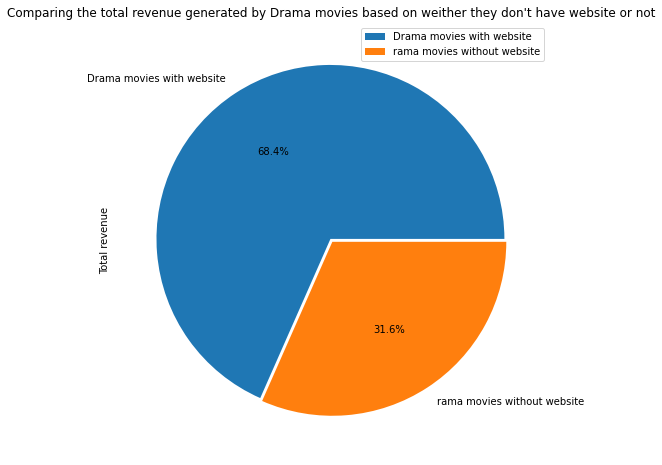

In [123]:
website_status_stats["revenue"].plot(kind="pie",
                              figsize=(8,8),
                              explode=[0.01, 0.01],
                              autopct='%1.1f%%',
                              labels=["Drama movies with website","rama movies without website"],
                              legend=True)

plt.ylabel("Total revenue")

plt.title("Comparing the total revenue generated by Drama movies based on weither they don't have website or not");

This plot make it clear that having a website is a great asset to generate greater revenue.

<a id='conclusions'></a>
## Conclusions

If interested in the movie business, we should invest in `Drama` genre, which currently is the one on trend on the market. In regard to the production companies that we should partner with, we have as option :
* Warner Bros., which produced the highest number of movie and generated the highest revenue
* Universal Pictures, which is ranked in the top 02 just behing Warner Bros.
* Paramount Pictures, which has ranked in the top 03 in term of generated revenue despite having being entrusted with less budget than many companies    

As a tactical option, we should also consider having a website in order to boost our sales.

While doing our investigation, we came accross 03 limitations :
* There are movies with a budget of 0 which have generated revenue. This is not logic. 
* There are movies which have generated no revenue, and the reason was not made clear. But our own investigation shows that those movies have made revenue nowadays. We theorized that those movie haven't generated revenue at the time our database was compiled. This may have mislead some conclusion we have made, specially since the older the movie, the higher the revenue in a given time frame (at least, theorically).
* The fact that we didn't have revenue and/or budget for some movies made it impossible for us to compute the productivity indice (for a given production company, it is the total generated revenue divided by the total allocated budget). This value would have allowed us to discover dark horse companies (companies which tend to produce higher revenue despite having being allocated with less budget). It would be a good option to consider cooperating with such companies.


Since movies tend to have more than one genre, we can optionally consider `Drama` as our main genre and search for some auxilliary genres in another analysis report.